# Import libraries

In [2]:
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, GroundWater, IrrigationManagement
from aquacrop.utils import prepare_weather, get_filepath
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from pathlib import Path
import geopandas as gpd
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pyodbc

from owslib.wcs import WebCoverageService

import xarray as xr

import rasterio
from rasterio.plot import show

from matplotlib import pyplot

import numpy as np

import glob as glob

import rioxarray

from pathlib import Path

import elevation

import cdsapi
import zipfile
import rioxarray as rio 
from tqdm import tqdm
from datetime import datetime as dt
import datetime
import schedule
import netCDF4 as nc
from netCDF4 import Dataset
import os, sys
import copy
import platform
import tempfile
import logging
from math import log10, cos, sin, asin, sqrt, exp, pi, radians
from collections import namedtuple
from bisect import bisect_left
import textwrap
import sqlite3
from collections import Iterable
from osgeo import gdal

from altitudo import altitudo

import traceback

from datetime import date, timedelta

/tmp/ipykernel_59479/2045799128.py:52: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [3]:
%load_ext sql

# Directories

In [4]:
DataDir = '/home/c4ubuntu/projDir/SADC/Data/'

# Functions

In [5]:
Celsius2Kelvin = lambda x: x + 273.16
hPa2kPa = lambda x: x/10.

# Saturated Vapour pressure [kPa] at temperature temp [C]
SatVapourPressure = lambda temp: 0.6108 * exp((17.27 * temp) / (237.3 + temp))

# Named tuple for returning results of ASTRO
astro_nt = namedtuple("AstroResults", "DAYL, DAYLP, SINLD, COSLD, DIFPP, "
                                      "ATMTR, DSINBE, ANGOT")
def astro(day, latitude, radiation, _cache={}):
    """python version of ASTRO routine by Daniel van Kraalingen.
    
    This subroutine calculates astronomic daylength, diurnal radiation
    characteristics such as the atmospheric transmission, diffuse radiation etc.
    :param day:         date/datetime object
    :param latitude:    latitude of location
    :param radiation:   daily global incoming radiation (J/m2/day)
    output is a `namedtuple` in the following order and tags::
        DAYL      Astronomical daylength (base = 0 degrees)     h      
        DAYLP     Astronomical daylength (base =-4 degrees)     h      
        SINLD     Seasonal offset of sine of solar height       -      
        COSLD     Amplitude of sine of solar height             -      
        DIFPP     Diffuse irradiation perpendicular to
                  direction of light                         J m-2 s-1 
        ATMTR     Daily atmospheric transmission                -      
        DSINBE    Daily total of effective solar height         s
        ANGOT     Angot radiation at top of atmosphere       J m-2 d-1
 
    Authors: Daniel van Kraalingen
    Date   : April 1991
 
    Python version
    Author      : Allard de Wit
    Date        : January 2011
    """

    # Check for range of latitude
    if abs(latitude) > 90.:
        msg = "Latitude not between -90 and 90"
        raise RuntimeError(msg)
    LAT = latitude
        
    # Determine day-of-year (IDAY) from day
    IDAY = doy(day)
    
    # reassign radiation
    AVRAD = radiation

    # Test if variables for given (day, latitude, radiation) were already calculated
    # in a previous run. If not (e.g. KeyError) calculate the variables, store
    # in cache and return the value.
    try:
        return _cache[(IDAY, LAT, AVRAD)]
    except KeyError:
        pass

    # constants
    RAD = radians(1.)
    ANGLE = -4.

    # Declination and solar constant for this day
    DEC = -asin(sin(23.45*RAD)*cos(2.*pi*(float(IDAY)+10.)/365.))
    SC  = 1370.*(1.+0.033*cos(2.*pi*float(IDAY)/365.))

    # calculation of daylength from intermediate variables
    # SINLD, COSLD and AOB
    SINLD = sin(RAD*LAT)*sin(DEC)
    COSLD = cos(RAD*LAT)*cos(DEC)
    AOB = SINLD/COSLD

    # For very high latitudes and days in summer and winter a limit is
    # inserted to avoid math errors when daylength reaches 24 hours in 
    # summer or 0 hours in winter.

    # Calculate solution for base=0 degrees
    if abs(AOB) <= 1.0:
        DAYL  = 12.0*(1.+2.*asin(AOB)/pi)
        # integrals of sine of solar height
        DSINB  = 3600.*(DAYL*SINLD+24.*COSLD*sqrt(1.-AOB**2)/pi)
        DSINBE = 3600.*(DAYL*(SINLD+0.4*(SINLD**2+COSLD**2*0.5))+
                 12.*COSLD*(2.+3.*0.4*SINLD)*sqrt(1.-AOB**2)/pi)
    else:
        if AOB >  1.0: DAYL = 24.0
        if AOB < -1.0: DAYL = 0.0
        # integrals of sine of solar height	
        DSINB = 3600.*(DAYL*SINLD)
        DSINBE = 3600.*(DAYL*(SINLD+0.4*(SINLD**2+COSLD**2*0.5)))

    # Calculate solution for base=-4 (ANGLE) degrees
    AOB_CORR = (-sin(ANGLE*RAD)+SINLD)/COSLD
    if abs(AOB_CORR) <= 1.0:
        DAYLP = 12.0*(1.+2.*asin(AOB_CORR)/pi)
    elif AOB_CORR > 1.0:
        DAYLP = 24.0
    elif AOB_CORR < -1.0:
        DAYLP = 0.0

    # extraterrestrial radiation and atmospheric transmission
    ANGOT = SC*DSINB
    # Check for DAYL=0 as in that case the angot radiation is 0 as well
    if DAYL > 0.0:
        ATMTR = AVRAD/ANGOT
    else:
        ATMTR = 0.

    # estimate fraction diffuse irradiation
    if (ATMTR > 0.75):
        FRDIF = 0.23
    elif (ATMTR <= 0.75) and (ATMTR > 0.35):
        FRDIF = 1.33-1.46*ATMTR
    elif (ATMTR <= 0.35) and (ATMTR > 0.07):
        FRDIF = 1.-2.3*(ATMTR-0.07)**2
    else:  # ATMTR <= 0.07
        FRDIF = 1.

    DIFPP = FRDIF*ATMTR*0.5*SC

    retvalue = astro_nt(DAYL, DAYLP, SINLD, COSLD, DIFPP, ATMTR, DSINBE, ANGOT)
    _cache[(IDAY, LAT, AVRAD)] = retvalue

    return retvalue

def doy(day):
    """Converts a date or datetime object to day-of-year (Jan 1st = doy 1)
    """
    # Check if day is a date or datetime object
    if isinstance(day, (datetime.date, datetime.datetime)):
        return day.timetuple().tm_yday
    else:
        msg = "Parameter day is not a date or datetime object."
        raise RuntimeError(msg)

def penman_monteith(DAY, LAT, ELEV, TMIN, TMAX, AVRAD, VAP, WIND2):
    """Calculates reference ET0 based on the Penman-Monteith model.
     This routine calculates the potential evapotranspiration rate from
     a reference crop canopy (ET0) in mm/d. For these calculations the
     analysis by FAO is followed as laid down in the FAO publication
     `Guidelines for computing crop water requirements - FAO Irrigation
     and drainage paper 56 <http://www.fao.org/docrep/X0490E/x0490e00.htm#Contents>`_
    Input variables::
        DAY   -  Python datetime.date object                   -
        LAT   -  Latitude of the site                        degrees
        ELEV  - Elevation above sea level                      m
        TMIN  - Minimum temperature                            C
        TMAX  - Maximum temperature                            C
        AVRAD - Daily shortwave radiation                   J m-2 d-1
        VAP   - 24 hour average vapour pressure               hPa
        WIND2 - 24 hour average windspeed at 2 meter          m/s
    Output is:
        ET0   - Penman-Monteith potential transpiration
                rate from a crop canopy                     [mm/d]
    """

    # psychrometric instrument constant (kPa/Celsius)
    PSYCON = 0.665
    # albedo and surface resistance [sec/m] for the reference crop canopy
    REFCFC = 0.23; CRES = 70.
    # latent heat of evaporation of water [J/kg == J/mm] and
    LHVAP = 2.45E6
    # Stefan Boltzmann constant (J/m2/d/K4, e.g multiplied by 24*60*60)
    STBC = 4.903E-3
    # Soil heat flux [J/m2/day] explicitly set to zero
    G = 0.

    # mean daily temperature (Celsius)
    TMPA = (TMIN+TMAX)/2.

    # Vapour pressure to kPa
    VAP = hPa2kPa(VAP)

    # atmospheric pressure at standard temperature of 293K (kPa)
    T = 293.0
    PATM = 101.3 * pow((T - (0.0065*ELEV))/T, 5.26)

    # psychrometric constant (kPa/Celsius)
    GAMMA = PSYCON * PATM * 1.0E-3

    # Derivative of SVAP with respect to mean temperature, i.e.
    # slope of the SVAP-temperature curve (kPa/Celsius);
    SVAP_TMPA = SatVapourPressure(TMPA)
    DELTA = (4098. * SVAP_TMPA)/pow((TMPA + 237.3), 2)

    # Daily average saturated vapour pressure [kPa] from min/max temperature
    SVAP_TMAX = SatVapourPressure(TMAX)
    SVAP_TMIN = SatVapourPressure(TMIN)
    SVAP = (SVAP_TMAX + SVAP_TMIN) / 2.

    # measured vapour pressure not to exceed saturated vapour pressure
    VAP = min(VAP, SVAP)

    # Longwave radiation according at Tmax, Tmin (J/m2/d)
    # and preliminary net outgoing long-wave radiation (J/m2/d)
    STB_TMAX = STBC * pow(Celsius2Kelvin(TMAX), 4)
    STB_TMIN = STBC * pow(Celsius2Kelvin(TMIN), 4)
    RNL_TMP = ((STB_TMAX + STB_TMIN) / 2.) * (0.34 - 0.14 * sqrt(VAP))

    # Clear Sky radiation [J/m2/DAY] from Angot TOA radiation
    # the latter is found through a call to astro()
    r = astro(DAY, LAT, AVRAD)
    CSKYRAD = (0.75 + (2e-05 * ELEV)) * r.ANGOT

    if CSKYRAD > 0:
        # Final net outgoing longwave radiation [J/m2/day]
        RNL = RNL_TMP * (1.35 * (AVRAD/CSKYRAD) - 0.35)

        # radiative evaporation equivalent for the reference surface
        # [mm/DAY]
        RN = ((1-REFCFC) * AVRAD - RNL)/LHVAP

        # aerodynamic evaporation equivalent [mm/day]
        EA = ((900./(TMPA + 273)) * WIND2 * (SVAP - VAP))

        # Modified psychometric constant (gamma*)[kPa/C]
        MGAMMA = GAMMA * (1. + (CRES/208.*WIND2))

        # Reference ET in mm/day
        ET0 = (DELTA * (RN-G))/(DELTA + MGAMMA) + (GAMMA * EA)/(DELTA + MGAMMA)
        ET0 = max(0., ET0)
    else:
        ET0 = 0.

    return ET0

In [6]:
def get_soil_name(lon, lat):
    Soils = {1:'SiltClay',2:'SandyClay',3:'ClayLoam',4:'SiltClayLoam',5:'SandyClayLoam',6:'Loam',7:'SandyLoam',8:'LoamySand',9:'Sand'}
    #Soil Class
    pnt_soil = gyga_soilclass.sel(x=lon,y=lat,  method="nearest")
    try:    
        pnt_class = int(pnt_soil.band_data.values)
        pnt_class_name = Soils.get(pnt_class)
    except:
        pnt_class_name = pnt_soil.band_data.values
    return(pnt_class_name)

In [7]:
def process_one_path(path):
    # use a context manager, to ensure the file gets closed after use
    with xr.open_dataset(path) as ds:
        ds.load()
        return ds

In [8]:
gyga_soilclass = xr.open_dataset(os.path.join(DataDir,'GIS/Soil/gyga_30cm_texclss_1km.tif'))
    
def get_soil_profile(lon, lat):
    Soils = {1:'SiltClay',2:'SandyClay',3:'ClayLoam',4:'SiltClayLoam',5:'SandyClayLoam',6:'Loam',7:'SandyLoam',8:'LoamySand',9:'Sand'}
    #Soil Class
    pnt_soil = gyga_soilclass.sel(x=lon,y=lat,  method="nearest")
    pnt_class = int(pnt_soil.band_data.values)
    pnt_class_name = Soils.get(pnt_class)
    # Custom Soil
    point_soil = Soil(soil_type=pnt_class_name, dz=[0.05]*2+[0.15]*2+[0.30]*2+[0.6]*2+[1.0]*2+[2.0]*2)
    
    depths = {'1':'0.5','2':'0.15','3':'0.30','4':'0.60','5':'1','6':'2'}
    
    for level in range(1,7):
        for var in ['SND','CLY']:
            filename = 'af_{}PPT_T__M_sd{}_250m_reprojected.tif'.format(var,level)
            if var == 'SND':
                sandtemp = process_one_path(os.path.join(DataDir,'GIS/Soil',filename))
                sandtemp = sandtemp.rio.write_crs(countries_adm.crs)
                sandtempval = sandtemp.sel(x=lon,y=lat,  method="nearest")
                sandtempdata = int(sandtempval.band_data.values)
               # sandtempdata = str(sandtempdata)
               # print(var, 'Level:',level, 'Value: ',sandtempdata)
            elif var == 'CLY':
                claytemp = process_one_path(os.path.join(DataDir,'GIS/Soil',filename))
                claytemp = claytemp.rio.write_crs(countries_adm.crs)
                claytempval = claytemp.sel(x=lon,y=lat,  method="nearest")
                claytempdata = int(claytempval.band_data.values)
               # claytempdata = str(claytempdata)
               # print(var, 'Level:',level, 'Value: ',claytempdata)
        dep = depths.get('{}'.format(level))
        dep = float(dep)
        point_soil.add_layer_from_texture(thickness=dep, Sand=sandtempdata, Clay=claytempdata,OrgMat=2.5,penetrability=100)
        
        return(point_soil)

In [9]:
def get_climate(lat, lon, climate):
    SiteFile = pd.DataFrame()
    Kelvin2Celsius = lambda x: x - 273.16
    dftmp = climate
    pnt = dftmp.sel(lat=lat,lon=lon,  method="nearest")
    df = pnt.to_dataframe()
    df = df.drop(columns={'lat','lon'})
    df.reset_index(inplace=True)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    
    SiteFile = df.rename(columns={'Wind_Speed_10m_Mean':'WIND2', 'Vapour_Pressure_Mean':'VAP',
                                        'Solar_Radiation_Flux':'AVRAD',
                                        'Precipitation_Flux':'Precipitation', 'Temperature_Air_2m_Max_24h':'MaxTemp',
                                        'Temperature_Air_2m_Min_24h':'MinTemp'})
    
    SiteFile['LAT'] = float(lat)
    SiteFile['ELEV'] = float(Elevation)
    SiteFile.index.names = ['Date']
    SiteFile[['MinTemp','MaxTemp']] = Kelvin2Celsius(SiteFile[['MinTemp','MaxTemp']])
    
    SiteFile.reset_index(inplace=True)
    
    print('Calculating Evapotranspiration')
    for idx, row in SiteFile.iterrows():
        SiteFile.loc[idx,'ReferenceET'] = penman_monteith(DAY=row['Date'], LAT=row['LAT'], 
                    ELEV=row['ELEV'],TMIN=row['MinTemp'],
                    TMAX=row['MaxTemp'],AVRAD=row['AVRAD'],
                    VAP=row['VAP'],WIND2=row['WIND2'])
    
    SiteFile = SiteFile[["MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]]
    return(SiteFile)

In [10]:
def get_plantdate_month(lat, lon, crop, irr_stat, weatherfile):
    calendar = xr.open_dataset(os.path.join(DataDir,'Crop/Crop_Calendar/{}_{}_ggcmi_crop_calendar_phase3_v1.01.nc4').format(crop, irr_stat))
    pnt_date = calendar.sel(lon=lon,lat=lat,  method="nearest")
    pnt_date = pnt_date.planting_day.values
    sdate = weatherfile.Date.dt.year.unique()[0]
    strt_date = date(int(sdate), 1, 1)
    plant_date = strt_date + timedelta(days=int(pnt_date) - 1)
    plant_date = plant_date.strftime("%m-%d")
    return(plant_date)

In [11]:
def get_plantcalendardate(lat, lon, crop, irr_stat, weatherfile):
    calendar = xr.open_dataset(os.path.join(DataDir,'Crop/Crop_Calendar/{}_{}_ggcmi_crop_calendar_phase3_v1.01.nc4').format(crop, irr_stat))
    pnt_date = calendar.sel(lon=lon,lat=lat,  method="nearest")
    pnt_date = pnt_date.planting_day.values
    sdate = weatherfile.Date.dt.year.unique()[0]
    strt_date = date(int(sdate), 1, 1)
    plant_date = strt_date + timedelta(days=int(pnt_date) - 1)
    plant_date = plant_date.strftime("%d-%m-%Y")
    return(plant_date)

In [12]:
def aggregate_yields(output_dir):
    out_files = glob.glob(os.path.join(DataDir,output_dir,'*.csv'))
    country_yield = pd.DataFrame()
    for file in out_files:
        dftmp = pd.read_csv(file, index_col=3)
        dftmp = dftmp[['crop Type',
           'Yield (tonne/ha)', 'Lat', 'Lon',
           'Watershed_No', 'Scenario']]
        if len(country_yield) == 0:
            country_yield = dftmp
        else:
            country_yield = pd.concat([country_yield, dftmp])
            
    country_yield.reset_index(inplace=True)
    country_yield.Lat = country_yield.Lat.astype(float)
    country_yield.Lon = country_yield.Lon.astype(float)
    country_yield.set_index(['Harvest Date (YYYY/MM/DD)','Lat','Lon','Watershed_No', 'Scenario','crop Type'], inplace=True)
    ds = country_yield.to_xarray()
    ds = ds.rename({'Harvest Date (YYYY/MM/DD)':'Year','Yield (tonne/ha)':'Yield (t/ha)'})
    return(ds)

In [13]:
def get_plantingdates(lat, lon, weatherfile, cropname):
    planting_dates = {}
    for year in weatherfile.Date.dt.year.unique():
        if year != 2022:
            year_clim = weatherfile.set_index('Date').loc['{}'.format(year)]
            year_clim.reset_index(inplace=True)
            plant_date = get_plantcalendardate(lat=lat, lon=lon, crop=cropname, irr_stat=irr_status, weatherfile=year_clim)
            start_window = pd.to_datetime(plant_date, infer_datetime_format=True)-pd.DateOffset(90)
            end_window = pd.to_datetime(plant_date, infer_datetime_format=True)+pd.DateOffset(90)
            window_clim_01 = year_clim.set_index('Date').resample('7D').sum()
            window_clim_02 = year_clim.set_index('Date').resample('14D').sum()
            arex_01 = window_clim_01[start_window:end_window].loc[window_clim_01['Precipitation']>25]
            arex_02 = window_clim_02[start_window:end_window].loc[window_clim_02['Precipitation']>40]
            arex = [i for i in arex_01.index if i in arex_02.index]
            if len(arex) > 0:
                arex = arex[0]+pd.DateOffset(7)
            else:
                try:
                    arex = arex_01.index[0]
                except:
                    arex = pd.to_datetime(plant_date, infer_datetime_format=True)
            planting_dates[year] = arex.strftime("%m-%d")
    return(planting_dates)

In [14]:
def run_aquacrop(country, scenario, wshed, start_sim, end_sim, weatherfile, soil, crop, initial_water, irrigation):
    model = AquaCropModel(sim_start_time=f'{start_sim}',
                                  sim_end_time=f'{end_sim}',
                                  weather_df=weatherfile,
                                  soil=soil,
                                  crop=crop,
                                  initial_water_content=initial_water,
                                  irrigation_management=irrigation)               
    try:
        model.run_model(till_termination=True)
        print('Model ran for ', lat, lon, year)
        out = model._outputs.final_stats
        out['Lat'] = lat
        out['Lon'] = lon
        out['Watershed_No'] = wshed
        scene = str(scenario.get('Name'))
        out['Scenario'] = scene
        out['Country'] = country
        out['Year'] = out['Harvest Date (YYYY/MM/DD)'].dt.year
    except:
        traceback_output = traceback.format_exc()
        print('Model didnt run for:', lat,lon,'Error:', traceback_output)
    return(out)

In [15]:
def get_startdate(year):
    try:
        start_sim = str(year) + '-' + planting_dates.get(year)
        start_sim = pd.to_datetime(start_sim)
        start_sim = start_sim - pd.DateOffset(90)
        start_sim = start_sim.strftime('%Y/%m/%d')
    except:
        print('No planting date: ', year, planting_dates.get(year))
    return(start_sim)

In [16]:
def get_enddate(year):
    try:
        end_sim = str(year) + '-' + planting_dates.get(year)
        end_sim = pd.to_datetime(end_sim)
        end_sim = end_sim + pd.DateOffset(365)
        end_sim = end_sim.strftime('%Y/%m/%d')
    except:
        print('No planting date: ', year, planting_dates.get(year))
    return(end_sim)

### Connect to PostGIS database

In [17]:
host = "c4postgis.postgres.database.azure.com"
database = "sadc"
user = 'Azure_admin'
password = '849uzZjXug7Lc8xL'

In [18]:
connection_string = f"postgresql://{user}:{password}@{host}/{database}"

In [19]:
engine = create_engine(connection_string)

In [20]:
insp = inspect(engine)
insp.get_table_names()

['africa_watersheds_level8',
 'spatial_ref_sys',
 't2m_24hr',
 'd2m_24hr',
 'countries_adm',
 'test_watersheds',
 'test_thi_cat_count_gt_72',
 'eswatini_rh',
 't2m_5hr',
 'd2m',
 't2m',
 'eswatini_recov',
 'eswatini',
 'd2m_5hr',
 'eswatini_thi',
 'test_point']

## Run Aquacrop

**ADM Boundaries**

In [21]:
countries = ['eSwatini','Zambia','Madagascar','Lesotho',' Zimbabwe','Malawi']

In [22]:
sql = 'SELECT * FROM countries_adm'

country_adm = gpd.read_postgis(sql, con=engine, geom_col='geometry')

In [23]:
countries_adm = country_adm.loc[country_adm.ADMIN.isin(countries)]

countries_adm.ADMIN.unique()

array(['Malawi', 'Zambia', 'eSwatini', 'Lesotho', 'Madagascar'],
      dtype=object)

**Watersheds**

In [24]:
combined_wsheds = gpd.read_file(os.path.join(DataDir,'GIS', 'combined_wsheds.shp'))
combined_wsheds = combined_wsheds.to_crs(country_adm.crs)

**Gridpoints**

- Original resolution

In [25]:
gridnc = xr.open_dataset(os.path.join(DataDir,'Climate','1_extraction','AgERA5_SADC_precipitation_flux_daily_2022','843c533e-8d59-4924-987d-476aae13475d-Precipitation-Flux_C3S-glob-agric_AgERA5_20221026_final-v1_area_subset.nc'))

gridnc = gridnc.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

gridnc = gridnc.rio.write_crs(countries_adm.crs)

gridnc_clipped = gridnc.rio.clip(countries_adm.geometry.values, 
                                 countries_adm.crs, drop=True, invert=False)

climgrid = gridnc_clipped.to_dataframe().dropna()

climgrid = climgrid.reset_index(level=['time','lat','lon'])

climgrid = climgrid[['lat','lon']].copy().drop_duplicates()

climgrid_points = gpd.GeoDataFrame(climgrid,crs=countries_adm.crs,
                                   geometry=gpd.points_from_xy(climgrid.lon,climgrid.lat)).dropna()

# Remove gridpoints in Water GEZ zone

gez = gpd.read_file(os.path.join(DataDir,'GIS','gez_2010_wgs84.shp'))

gez = gez.to_crs(climgrid_points.crs)

climgrid_points = gpd.sjoin(climgrid_points,gez,predicate='within')

climgrid_points.loc[climgrid_points['gez_name']=='Water'] = np.nan

climgrid_points.dropna(inplace=True)

# Remove gridpoints in Waterbodies

africa_waterbodies = gpd.read_file(os.path.join(DataDir,'GIS','nd124my6773.shp'))

africa_waterbodies = africa_waterbodies.to_crs(climgrid_points.crs)

climgrid_points.drop(columns='index_right', inplace=True)

climgrid_points = gpd.sjoin(climgrid_points,africa_waterbodies,how='left',predicate='within')

climgrid_points.loc[climgrid_points['index_right'].notna()] = np.nan

climgrid_points.dropna(how='all',inplace=True)

climgrid_points.drop(columns='index_right', inplace=True)

ERROR 1: PROJ: proj_identify: /home/c4ubuntu/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /home/c4ubuntu/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


- Reduced gridpoints

In [32]:
gridnc = xr.open_dataset(os.path.join(DataDir,'Climate','1_extraction','AgERA5_SADC_precipitation_flux_daily_2022','843c533e-8d59-4924-987d-476aae13475d-Precipitation-Flux_C3S-glob-agric_AgERA5_20221026_final-v1_area_subset.nc'))

gridnc = gridnc.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

gridnc = gridnc.rio.write_crs(countries_adm.crs)

gridnc = gridnc.coarsen(lon=2,lat=2, boundary='trim').mean()

gridnc_clipped = gridnc.rio.clip(countries_adm.geometry.values, 
                                 countries_adm.crs, drop=True, invert=False)


climgrid = gridnc_clipped.to_dataframe().dropna()

climgrid = climgrid.reset_index(level=['time','lat','lon'])

climgrid = climgrid[['lat','lon']].copy().drop_duplicates()

climgrid_points = gpd.GeoDataFrame(climgrid,crs=countries_adm.crs,
                                   geometry=gpd.points_from_xy(climgrid.lon,climgrid.lat)).dropna()

# Remove gridpoints in Water GEZ zone

gez = gpd.read_file(os.path.join(DataDir,'GIS','gez_2010_wgs84.shp'))

gez = gez.to_crs(climgrid_points.crs)

climgrid_points = gpd.sjoin(climgrid_points,gez,predicate='within')

climgrid_points.loc[climgrid_points['gez_name']=='Water'] = np.nan

climgrid_points.dropna(inplace=True)

africa_waterbodies = gpd.read_file(os.path.join(DataDir,'GIS','nd124my6773.shp'))

africa_waterbodies = africa_waterbodies.to_crs(climgrid_points.crs)

climgrid_points.drop(columns='index_right', inplace=True)

climgrid_points = gpd.sjoin(climgrid_points,africa_waterbodies,how='left',predicate='within')

climgrid_points.loc[climgrid_points['index_right'].notna()] = np.nan

climgrid_points.dropna(how='all',inplace=True)

climgrid_points.drop(columns='index_right', inplace=True)

ERROR 1: PROJ: proj_identify: /home/c4ubuntu/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /home/c4ubuntu/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [33]:
climgrid_points.to_file('reducedpoints.shp')

**Soil**

In [25]:
# Soil Class 
gyga_soilclass = xr.open_dataset(os.path.join(DataDir,'GIS/Soil/gyga_30cm_texclss_1km.tif'))

# Root Zone Depth
gyga_rootzonedepth = xr.open_dataset(os.path.join(DataDir,'GIS/Soil/gyga_af_erzd__m_1km_rootzonedepth.tif'))

**Climate**

In [26]:
climdat = xr.open_mfdataset(glob.glob(os.path.join('Data/Climate/3_combined/','*SADC*')), parallel=True)

**Run Model**

In [27]:
for i in countries_adm.ADMIN.unique()[2:4]:
    print(i)

eSwatini
Lesotho


In [28]:
Scenario =  [{'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'SugarCane', 'Irrigation':'ir'},
          {'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Maize', 'Irrigation':'ir'},
            {'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Sorghum', 'Irrigation':'ir'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Maize', 'Irrigation':'rf'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'SugarCane', 'Irrigation':'rf'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Sorghum', 'Irrigation':'rf'}]

Combined = pd.DataFrame()

for country in countries_adm.ADMIN.unique()[2:4]:
    start=dt.now()
    Aggregated = pd.DataFrame()
    print('Starting with ', country)
    countryshape = countries_adm.loc[countries_adm.ADMIN == country]
    country_wsheds = gpd.clip(combined_wsheds,countryshape)
    wshed_count = len(country_wsheds.HYBAS_ID.unique())
    n = 1
    for wshed in country_wsheds.HYBAS_ID.unique():
        print('Running watershed ', n, 'out of ', wshed_count)
        n = n+1
        n_wshed = country_wsheds.loc[country_wsheds.HYBAS_ID == wshed]
        wshed_grid = gpd.sjoin(climgrid_points, n_wshed, predicate='within')
        if len(wshed_grid) >0:
            gp = 1
            for idx, row in wshed_grid.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                #print(lat, lon)
                # Elevation
                try:
                    Elevation = altitudo(lat=[lat], lon=[lon])
                    Elevation = Elevation[0].get('elevation')
                except:
                    print('Something wrong with elevation')
                # Soil profile
                try:
                    point_soil = get_soil_profile(lon=lon, lat=lat)
                except:
                    point_soil = get_soil_name(lon=lon, lat=lat)
                 
                # Climate
                SiteFile = get_climate(lat=lat, lon=lon,climate=climdat)               
                # Run scenarios for a specific grid point
                for scenario in Scenario:
                # Scenario
                    scene = scenario.get('Name')
                # Cropname and Irrigation
                    cropname = scenario.get('Crop')
                    irr_status = scenario.get('Irrigation')
                    
                    print('Running {} {} for gridpoint'.format(scene,cropname), gp, 'out of ', len(wshed_grid))
                    gp = gp+1
                # Root Zone Depth
                    pnt_rootzoneD = gyga_rootzonedepth.sel(x=lon,y=lat,  method="nearest")
                    if pd.isna(pnt_rootzoneD.band_data.values) == True:
                        pnt_rootzoneD = 0
                    else:  
                        pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Planting date
                    planting_dates = get_plantingdates(lat=lat, lon=lon, weatherfile=SiteFile, cropname=cropname)    
                # Initial water
                    InitWC = InitialWaterContent(value=['FC'])
                # Irrigation
                    irr_num = scenario.get('IrrNum')
                    soilmt = scenario.get('SMT')
                    
                    if soilmt is None:
                        net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                    else:
                        net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))          
                # Run model for each year    
                    for year in SiteFile.Date.dt.year.unique():
                        if ((year > SiteFile.Date.dt.year.min())) and ((year < SiteFile.Date.dt.year.max())):
                    # Crop
                            if cropname == 'Maize':
                                crop_sim = Crop('Maize', planting_date='{}'.format(planting_dates.get(year)), Zmax=pnt_rootzoneD)
                            else:
                                crop_sim = Crop('{}'.format(cropname), planting_date='{}'.format(planting_dates.get(year)))
                    # end Date
                            start_sim = get_startdate(year=year)
                            end_sim = get_enddate(year=year)
                            #print('Year: ',year, 'Country:', country,cropname, planting_dates.get(year), start_sim, end_sim)
                    # Run Aquacrop
                            model = AquaCropModel(sim_start_time=f'{start_sim}',
                                  sim_end_time=f'{end_sim}',
                                  weather_df=SiteFile,
                                  soil=point_soil,
                                  crop=crop_sim,
                                  initial_water_content=InitWC,
                                  irrigation_management=net_irrigation)
                        
                            try:
                                model.run_model(till_termination=True)
                                #print('Model ran for ', lat, lon, year)
                                out = model._outputs.final_stats
                                out['Lat'] = lat
                                out['Lon'] = lon
                                out['Watershed_No'] = wshed
                                scene = str(scenario.get('Name'))
                                out['Scenario'] = scene
                                out['Country'] = country
                                out['Year'] = out['Harvest Date (YYYY/MM/DD)'].dt.year
                    
                                    
                                if len(Aggregated) == 0:
                                    Aggregated = out
                                else:
                                    Aggregated = pd.concat([Aggregated, out])
                            except:
                                traceback_output = traceback.format_exc()
                                #print('Model didnt run for:', lat,lon,'Error:', traceback_output)
    print('Finished with ', country, '. Ran for ',dt.now()-start)
    Aggregated.to_csv((os.path.join(DataDir,'Output','CSVs','{}_Yield_{}.csv'.format(country, start))))

Starting with  eSwatini
Running watershed  1 out of  34


TypeError: object of type 'Soil' has no len()

In [41]:
glob.glob(os.path.join(DataDir,'Output','CSVs','*'))

['/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Maize_Low_Input_1081608210_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Maize_Low_Input_1081608140_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Maize_Low_Input_1081605920_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Maize_Low_Input_1081605930_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Maize_Low_Input_1081601440_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Maize_Low_Input_1081601360_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Maize_Low_Input_1081601690_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Maize_Low_Input_1081600680_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Sorghum_High_Input_1081600970_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Swaziland_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Maize_High_Input_1081599280_yield.csv',
 '/home/c4ubuntu/projDir/SADC/Data/Output/CSVs/Maize_High_Input_108

In [40]:
#Combined.to_csv((os.path.join(DataDir,'Output','CSVs','Swaziland_yield.csv')))

In [34]:
Combined = pd.read_csv(os.path.join(DataDir,'Output','CSVs','eSwatini_Yield_2023-01-03 08:13:40.665003.csv'))

In [35]:
Combined.Watershed_No.unique()

array([1081609500, 1081606180, 1081608140, 1081601440, 1081600610])

In [36]:
high_input_maize_copy = Combined[['Year','Lat', 'Lon','crop Type',
                                'Scenario','Watershed_No','Country','Yield (tonne/ha)']]

In [37]:
test = high_input_maize_copy.groupby(['Lat','Lon','Year','Watershed_No']).mean()

In [38]:
ds = test.to_xarray()

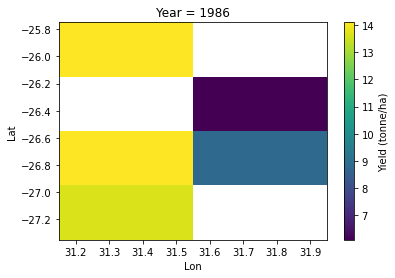

In [43]:
ds['Yield (tonne/ha)'].mean(dim='Watershed_No')[:,:,5].plot()

In [283]:
ds['Yield (tonne/ha)'][:,:,0,:]

<xarray.DataArray 'Yield (tonne/ha)' (Lat: 16, Lon: 14, Watershed_No: 31)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 6.62262721,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * Lat           (Lat) float64 -27.3 -27.2 -27.1 -27.0 ... -26.0 -25.9 -25.8
  * Lon           (Lon) float64 30.8 30.9 31.0 31.1 31.2 ... 31.8 31.9 32.0 32.1
    Year          int64 1981
  * Watershed_No  (Watershed_No) int64 1080012770 1081596080 ... 1081613850

# Dask stuff

In [ ]:
from dask.distributed import Client

client = Client(n_workers=4)
client

climdat = xr.open_mfdataset(glob.glob(os.path.join('Data/Climate/3_combined/','*SADC*')), parallel=True)

test = climdat.sel(lat=climgrid_points.iloc[0].lat,lon=climgrid_points.iloc[0].lon, method='nearest')

test = test.to_dask_dataframe()

test

test = climdat.sel(lat=climgrid_points.iloc[0].lat,lon=climgrid_points.iloc[0].lon, method='nearest')
test = test.to_dask_dataframe()
Elevation = 1000
df = test.drop(columns={'lon'})
Kelvin2Celsius = lambda x: x - 273.16

SiteFile = df.rename(columns={'Wind_Speed_10m_Mean':'WIND2', 'Vapour_Pressure_Mean':'VAP',
                                    'Solar_Radiation_Flux':'AVRAD',
                                    'Precipitation_Flux':'Precipitation', 'Temperature_Air_2m_Max_24h':'MaxTemp',
                                    'Temperature_Air_2m_Min_24h':'MinTemp', 'lat':'LAT', 'time':'Date'})

SiteFile['ELEV'] = float(Elevation)

SiteFile['MaxTemp'] = SiteFile['MaxTemp'].apply(lambda x: x - 273.16, meta=('MaxTemp', 'float64')).compute()
SiteFile['MinTemp'] = SiteFile['MinTemp'].apply(lambda x: x - 273.16, meta=('MinTemp', 'float64')).compute()

%%time

SiteFile['ReferenceET'] = SiteFile.apply(
         lambda row: penman_monteith(DAY=row['Date'], LAT=row['LAT'], 
                    ELEV=row['ELEV'],TMIN=row['MinTemp'],
                    TMAX=row['MaxTemp'],AVRAD=row['AVRAD'],
                    VAP=row['VAP'],WIND2=row['WIND2']), meta=('ReferenceET', 'float64'), axis=1).compute()



In [ ]:
- Reduced resolution

gridnc = xr.open_dataset(os.path.join(DataDir,'Climate','1_extraction','AgERA5_SADC_precipitation_flux_daily_2022','843c533e-8d59-4924-987d-476aae13475d-Precipitation-Flux_C3S-glob-agric_AgERA5_20221026_final-v1_area_subset.nc'))

gridnc = gridnc.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

gridnc = gridnc.rio.write_crs(countries_adm.crs)

gridnc = gridnc.coarsen(lon=4,lat=4, boundary='trim').mean()

gridnc_clipped = gridnc.rio.clip(countries_adm.geometry.values, 
                                 countries_adm.crs, drop=True, invert=False)


climgrid = gridnc_clipped.to_dataframe().dropna()

climgrid = climgrid.reset_index(level=['time','lat','lon'])

climgrid = climgrid[['lat','lon']].copy().drop_duplicates()

climgrid_points = gpd.GeoDataFrame(climgrid,crs=countries_adm.crs,
                                   geometry=gpd.points_from_xy(climgrid.lon,climgrid.lat)).dropna()

# Remove gridpoints in Water GEZ zone

gez = gpd.read_file(os.path.join(DataDir,'GIS','gez_2010_wgs84.shp'))

gez = gez.to_crs(climgrid_points.crs)

climgrid_points = gpd.sjoin(climgrid_points,gez,predicate='within')

climgrid_points.loc[climgrid_points['gez_name']=='Water'] = np.nan

climgrid_points.dropna(inplace=True)

africa_waterbodies = gpd.read_file(os.path.join(DataDir,'GIS','nd124my6773.shp'))

africa_waterbodies = africa_waterbodies.to_crs(climgrid_points.crs)

climgrid_points.drop(columns='index_right', inplace=True)

climgrid_points = gpd.sjoin(climgrid_points,africa_waterbodies,how='left',predicate='within')

climgrid_points.loc[climgrid_points['index_right'].notna()] = np.nan

climgrid_points.dropna(how='all',inplace=True)

climgrid_points.drop(columns='index_right', inplace=True)

In [257]:
high_input_maize_copy = high_input_maize_copy.loc[(high_input_maize_copy['Scenario']=='High_Input')
                                                    & (high_input_maize_copy['crop Type']=='Maize')]

In [261]:
high_input_maize_copy

,,,,,,,Yield (tonne/ha)
Year,Lat,Lon,Watershed_No,Scenario,crop Type,Country,
1981,-27.3,31.5,1081613260,High_Input,Maize,eSwatini,14.067828
1982,-27.3,31.5,1081613260,High_Input,Maize,eSwatini,13.607584
1983,-27.3,31.5,1081613260,High_Input,Maize,eSwatini,13.554642
1984,-27.3,31.5,1081613260,High_Input,Maize,eSwatini,14.080223
1985,-27.3,31.5,1081613260,High_Input,Maize,eSwatini,13.708611
...,...,...,...,...,...,...,...
2016,-25.8,31.5,1081596080,High_Input,Maize,eSwatini,14.562231
2017,-25.8,31.5,1081596080,High_Input,Maize,eSwatini,14.644038
2018,-25.8,31.5,1081596080,High_Input,Maize,eSwatini,14.529776


In [258]:
high_input_maize_copy.set_index(['Year','Lat','Lon','Watershed_No', 
                                                        'Scenario','crop Type', 'Country'], inplace=True)

In [259]:
high_input_maize_copy

,,,,,,,Yield (tonne/ha)
Year,Lat,Lon,Watershed_No,Scenario,crop Type,Country,
1981,-27.3,31.5,1081613260,High_Input,Maize,eSwatini,14.067828
1982,-27.3,31.5,1081613260,High_Input,Maize,eSwatini,13.607584
1983,-27.3,31.5,1081613260,High_Input,Maize,eSwatini,13.554642
1984,-27.3,31.5,1081613260,High_Input,Maize,eSwatini,14.080223
1985,-27.3,31.5,1081613260,High_Input,Maize,eSwatini,13.708611
...,...,...,...,...,...,...,...
2016,-25.8,31.5,1081596080,High_Input,Maize,eSwatini,14.562231
2017,-25.8,31.5,1081596080,High_Input,Maize,eSwatini,14.644038
2018,-25.8,31.5,1081596080,High_Input,Maize,eSwatini,14.529776


In [260]:
ds = high_input_maize_copy.to_xarray()

ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray

In [124]:
high_input_maize_copy = high_input_maize.set_index(['Year','Lat','Lon','Scenario','Watershed_No','crop Type'])

In [123]:
high_input_maize_copy

Season crop Type  \
Lon   Lat    Year Scenario   Watershed_No                     
31.50 -27.30 1981 High_Input 1081613260         0     Maize   
             1982 High_Input 1081613260         0     Maize   
             1983 High_Input 1081613260         0     Maize   
             1984 High_Input 1081613260         0     Maize   
             1985 High_Input 1081613260         0     Maize   

                                          Harvest Date (YYYY/MM/DD)  \
Lon   Lat    Year Scenario   Watershed_No                             
31.50 -27.30 1981 High_Input 1081613260                  1981-03-23   
             1982 High_Input 1081613260                  1982-01-13   
             1983 High_Input 1081613260                  1983-01-13   
             1984 High_Input 1081613260                  1984-03-23   
             1985 High_Input 1081613260                  1985-01-12   

                                           Harvest Date (Step)  \
Lon   Lat    Year Scenario   Watershed_No                        
31.50 -27.30 1981 High_Input 1081613260                    221   
             1982 High_Input 1081613260                    221   
             1983 High_Input 1081613260                    221   
             1984 High_Input 1081613260                    221   
             1985 High_Input 1081613260                    221   

                                           Yield (tonne/ha)  \
Lon   Lat    Year Scenario   Watershed_No                     
31.50 -27.30 1981 High_Input 1081613260           14.067828   
             1982 High_Input 1081613260           13.607584   
             1983 High_Input 1081613260           13.554642   
             1984 High_Input 1081613260           14.080223   
             1985 High_Input 1081613260           13.708611   

                                           Seasonal irrigation (mm)   Country  
Lon   Lat    Year Scenario   Watershed_No                                      
31.50 -27.30 1981 High_Input 1081613260                  160.418797  eSwatini  
             1982 High_Input 1081613260                  192.440715  eSwatini  
             1983 High_Input 1081613260                  213.852541  eSwatini  
             1984 High_Input 1081613260                  173.444801  eSwatini  
             1985 High_Input 1081613260                   97.743159  eSwatini

In [ ]:

Scenario =  [{'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'SugarCane', 'Irrigation':'ir'},
          {'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Maize', 'Irrigation':'ir'},
            {'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Sorghum', 'Irrigation':'ir'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Maize', 'Irrigation':'rf'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'SugarCane', 'Irrigation':'rf'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Sorghum', 'Irrigation':'rf'}]

Combined = pd.DataFrame()



for country in countries_adm.ADMIN.unique()[2:3]:
    Aggregated = pd.DataFrame()
    countryshape = countries_adm.loc[countries_adm.ADMIN == country]
    country_wsheds = gpd.clip(combined_wsheds,countryshape)
    for wshed in country_wsheds.HYBAS_ID.unique()[0:1]:
        n_wshed = country_wsheds.loc[country_wsheds.HYBAS_ID == wshed]
        wshed_grid = gpd.sjoin(climgrid_points, n_wshed, predicate='within')
        if len(wshed_grid) >0:
            for idx, row in wshed_grid.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                # Climate
                SiteFile = get_climate(lat=lat, lon=lon)                
                # Run scenarios for a specific grid point
                for scenario in Scenario:
                # Scenario
                    scene = scenario.get('Name')
                    print(scene)
                # Cropname and Irrigation
                    cropname = scenario.get('Crop')
                    irr_status = scenario.get('Irrigation')
                # Root Zone Depth
                    pnt_rootzoneD = gyga_rootzonedepth.sel(x=lon,y=lat,  method="nearest")
                    pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                    try:
                        Elevation = altitudo(lat=[lat], lon=[lon])
                        Elevation = Elevation[0].get('elevation')
                    except:
                        print('Something wrong with elevation')
                # Soil profile
                    try:
                        point_soil = get_soil_profile(lon=lon, lat=lat)
                    except:
                        print('Soil didnt work for', lat,lon)
                # Planting date
                    planting_dates = get_plantingdates(lat=lat, lon=lon, weatherfile=SiteFile)    
                # Initial water
                    InitWC = InitialWaterContent(value=['FC'])
                # Irrigation
                    irr_num = scenario.get('IrrNum')
                    soilmt = scenario.get('SMT')
                    
                    if soilmt is None:
                        net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                    else:
                        net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))          

                # Run model for each year    
                    for year in SiteFile.Date.dt.year.unique():
                        if ((year >= 1980)) and ((year <= 2019)):
                    # Crop
                            if cropname == 'Maize':
                                crop_sim = Crop('Maize', planting_date='{}'.format(planting_dates.get(year)), Zmax=pnt_rootzoneD)
                            else:
                                crop_sim = Crop('{}'.format(cropname), planting_date='{}'.format(planting_dates.get(year)))
                    # end Date
                            start_sim = get_startdate(year=year)
                            end_sim = get_enddate(year=year)
                            print('Year: ',year, 'Country:', country,cropname, planting_dates.get(year), start_sim, end_sim)
                    # Run Aquacrop
                            output = run_aquacrop(country, scene, wshed, start_sim, end_sim, SiteFile,
                                                    point_soil, crop_sim, InitWC, net_irrigation)
                            if len(Aggregated) == 0:
                                Aggregated = output
                            else:
                                Aggregated = pd.concat([Aggregated, output], axis=0)

        Aggregated.to_csv(os.path.join(DataDir,'Output','CSVs','{}_yield.csv'.format(country)))

Calculating Evapotranspiration
High_Input
Year:  1980 Country: eSwatini SugarCane 01-08 1979/10/10 1981/01/07
Model didnt run for: -27.30 31.50 Error: Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 545, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2131, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2140, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 347760000000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 513, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 547, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('1981-01-08 00:00

UnboundLocalError: local variable 'out' referenced before assignment

In [92]:
Scenario =  [{'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'SugarCane', 'Irrigation':'ir'},
          {'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Maize', 'Irrigation':'ir'},
            {'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Sorghum', 'Irrigation':'ir'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Maize', 'Irrigation':'rf'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'SugarCane', 'Irrigation':'rf'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Sorghum', 'Irrigation':'rf'}]

Combined = pd.DataFrame()

Aggregated = pd.DataFrame()

for scenario in Scenario:
    print(scenario.get('Name'))
    for wshed in country_wsheds.hybas_id.unique()[0:1]:
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                # Metadata
                cropname = scenario.get('Crop')
                irr_status = scenario.get('Irrigation')
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                try:
                    Elevation = altitudo(lat=[lat], lon=[lon])
                    Elevation = Elevation[0].get('elevation')
                except:
                    print('Something wrong with elevation')
                # Soil profile
                try:
                    point_soil = get_soil_profile(lon=lon, lat=lat)
                except:
                    print('Soil didnt work for', lat,lon)
               # Climate
                SiteFile = get_climate(lat=lat, lon=lon)
                # Planting date
                planting_dates = get_plantingdates(lat=lat, lon=lon, weatherfile=SiteFile)
                    
                 # Initial water
                InitWC = InitialWaterContent(value=['FC'])  
                
                # Irrigation
                irr_num = scenario.get('IrrNum')
                soilmt = scenario.get('SMT')
                
                if soilmt is None:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                else:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))          
                           
                for year in SiteFile.Date.dt.year.unique():
                    if year != '2022':
                        # Crop
                        if cropname == 'Maize':
                            crop_sim = Crop('Maize', planting_date='{}'.format(planting_dates.get(year)), Zmax=pnt_rootzoneD)
                        else:
                            crop_sim = Crop('{}'.format(cropname), planting_date='{}'.format(planting_dates.get(year)))
                        # Start Date
                        start_sim = get_startdate(year=year)
                        print(start_sim)
                    
                    #print('Year: ',year, 'Planting date: ', planting_dates.get(year))
                        

High_Input


NameError: name 'gridpoints' is not defined

In [98]:
def get_startdate(year):
    start_date = str(year) + '-' + planting_dates.get(year)
    start_date = pd.to_datetime(start_date)
    start_date = start_date - pd.DateOffset(90)
    start_date = start_date.strftime('%Y/%m/%d')
    return(start_date)

In [96]:
def get_startdate(year):
    try:
        start_date = str(year) + '-' + planting_dates.get(year)
        start_date = pd.to_datetime(start_date)
        start_date = start_date - pd.DateOffset(90)
        start_date = start_date.strftime('%Y/%m/%d')
    except:
        print('No planting date: ', planting_dates.get(year))
    return(start_date)

In [ ]:
def run_aquacrop(start_sim, end_sim, weatherfile, soil, crop, initial_water, irrigation, output_dir):
    model = AquaCropModel(sim_start_time=f'{start_sim}',
                                  sim_end_time=f'{end_sim}',
                                  weather_df=weatherfile,
                                  soil=soil,
                                  crop=crop,
                                  initial_water_content=initial_water,
                                  irrigation_management=irrigation)               
    try:
        model.run_model(till_termination=True)
        print('Model ran for ', lat, lon, year)
        out = model._outputs.final_stats
        out['Lat'] = lat
        out['Lon'] = lon
        out['Watershed_No'] = wshed
        scene = str(scenario.get('Name'))
        out['Scenario'] = scene
        out['Year'] = out['Harvest Date (YYYY/MM/DD)'].dt.year
    except:
        traceback_output = traceback.format_exc()
        print('Model didnt run for:', lat,lon,'Error:', traceback_output)
    out.to_csv(os.path.join(DataDir,'Output','CSVs','{}_{}_{}_yield.csv'.format(cropname, scene, wshed)))
    return(out)


    if len(Combined) == 0:
        Combined = out
    else:
        Combined = pd.concat([Combined, out])
        
    Watershed = Combined[['crop Type','Harvest Date (Step)', 'Yield (tonne/ha)',
                          'Seasonal irrigation (mm)','Lat', 'Lon', 'Watershed_No', 
                                              'Scenario', 'Year']]
    
    

In [175]:
#Scenario =  [{'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Maize', 'Irrigation':'ir'},
 #           {'Name':'Low_Input','IrrNum':'0','Crop':'Maize', 'Irrigation':'rf'}]

Scenario =  [{'Name':'Low_Input','IrrNum':'0','Crop':'Maize', 'Irrigation':'rf'}]

Combined = pd.DataFrame()

Aggregated = pd.DataFrame()

for scenario in Scenario:
    print(scenario.get('Name'))
    for wshed in country_wsheds.hybas_id.unique()[0:]:
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                # Metadata
                cropname = scenario.get('Crop')
                irr_status = scenario.get('Irrigation')
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                try:
                    Elevation = altitudo(lat=[lat], lon=[lon])
                    Elevation = Elevation[0].get('elevation')
                except:
                    print('Something wrong with elevation')
                # Soil profile
                try:
                    point_soil = get_soil_profile(lon=lon, lat=lat)
                except:
                    print('Soil didnt work for', lat,lon)
               # Climate
                SiteFile = get_climate(lat=lat, lon=lon)
                # Planting date
                

                 # Initial water
                InitWC = InitialWaterContent(value=['FC'])  
                
                # Irrigation
                irr_num = scenario.get('IrrNum')
                soilmt = scenario.get('SMT')
                
                if soilmt is None:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                else:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))
                    
                planting_dates = {}
                for year in SiteFile.Date.dt.year.unique():
                    if year != 2022:
                        year_clim = SiteFile.set_index('Date').loc['{}'.format(year)]
                        year_clim.reset_index(inplace=True)
                        plant_date = get_plantdate(lat=lat, lon=lon, crop=cropname, irr_stat=irr_status, weatherfile=year_clim)
                        start_window = pd.to_datetime(plant_date, infer_datetime_format=True)-pd.DateOffset(90)
                        end_window = pd.to_datetime(plant_date, infer_datetime_format=True)+pd.DateOffset(90)
                        window_clim = year_clim.set_index('Date').resample('7D').sum()
                        arex = window_clim[start_window:end_window].loc[window_clim['Precipitation']>25].index[0]
                        planting_dates[year] = arex.strftime("%m-%d")
                        start_sim = arex-pd.DateOffset(90)
                        start_sim = start_sim.strftime('%Y/%m/%d')
                        end_sim = arex+pd.DateOffset(150)
                        end_sim = end_sim.strftime('%Y/%m/%d')
                        new_clim = SiteFile.set_index('Date').loc[start_sim:end_sim]
                        new_clim.reset_index(inplace=True)
                        
                        
                        # Crop
                        if cropname == 'Maize':
                            crop_sim = Crop('Maize', planting_date='{}'.format(planting_dates.get(year)), Zmax=pnt_rootzoneD)
                        else:
                            crop_sim = Crop('{}'.format(cropname), planting_date='{}'.format(planting_dates.get(year)))
                        
                        # Run the model
                        model = AquaCropModel(sim_start_time=f'{start_sim}',
                                  sim_end_time=f'{end_sim}',
                                  weather_df=SiteFile,
                                  soil=point_soil,
                                  crop=crop_sim,
                                  initial_water_content=InitWC,
                                  irrigation_management=net_irrigation)
                        
                        try:
                            model.run_model(till_termination=True)
                            print('Model ran for ', lat, lon, year)
                            out = model._outputs.final_stats
                            out['Lat'] = lat
                            out['Lon'] = lon
                            out['Watershed_No'] = wshed
                            scene = str(scenario.get('Name'))
                            out['Scenario'] = scene
                            out['Year'] = out['Harvest Date (YYYY/MM/DD)'].dt.year
                        except:
                            traceback_output = traceback.format_exc()
                            print('Model didnt run for:', lat,lon,'Error:', traceback_output)
                        
                        if len(Combined) == 0:
                            Combined = out
                        else:
                            Combined = pd.concat([Combined, out])
                            
                        Watershed = Combined[['crop Type','Harvest Date (Step)', 'Yield (tonne/ha)',
                                              'Seasonal irrigation (mm)','Lat', 'Lon', 'Watershed_No', 
                                              'Scenario', 'Year']]
  #  if len(Aggregated) == 0:
  #      Aggregated = Watershed
  #  else:
  #      Aggregated = pd.concat([Aggregated, Watershed])
                        
    # Write to csv
    #out.to_csv(os.path.join(DataDir,'Output','CSVs','{}_{}_{}_yield.csv'.format(cropname, scene, wshed)))"""

Low_Input
Soil didnt work for -26.00 31.60
Calculating Evapotranspiration
Model ran for  -26.00 31.60 1979
Model ran for  -26.00 31.60 1980
Model ran for  -26.00 31.60 1981
Model ran for  -26.00 31.60 1982
Model ran for  -26.00 31.60 1983
Model ran for  -26.00 31.60 1984
Model ran for  -26.00 31.60 1985
Model ran for  -26.00 31.60 1986
Model ran for  -26.00 31.60 1987
Model ran for  -26.00 31.60 1988
Model ran for  -26.00 31.60 1989
Model ran for  -26.00 31.60 1990
Model ran for  -26.00 31.60 1991
Model ran for  -26.00 31.60 1992
Model ran for  -26.00 31.60 1993
Model ran for  -26.00 31.60 1994
Model ran for  -26.00 31.60 1995
Model ran for  -26.00 31.60 1996
Model ran for  -26.00 31.60 1997
Model ran for  -26.00 31.60 1998
Model ran for  -26.00 31.60 1999
Model ran for  -26.00 31.60 2000
Model ran for  -26.00 31.60 2001
Model ran for  -26.00 31.60 2002
Model ran for  -26.00 31.60 2003
Model ran for  -26.00 31.60 2004
Model ran for  -26.00 31.60 2005
Model didnt run for: -26.00 31.60 E

Model ran for  -26.00 32.00 2009
Model ran for  -26.00 32.00 2010
Model ran for  -26.00 32.00 2011
Model ran for  -26.00 32.00 2012
Model ran for  -26.00 32.00 2013
Model ran for  -26.00 32.00 2014
Model ran for  -26.00 32.00 2015
Model ran for  -26.00 32.00 2016
Model ran for  -26.00 32.00 2017
Model ran for  -26.00 32.00 2018
Model ran for  -26.00 32.00 2019
Model ran for  -26.00 32.00 2020
Model ran for  -26.00 32.00 2021
Soil didnt work for -26.00 31.40
Calculating Evapotranspiration
Model ran for  -26.00 31.40 1979
Model ran for  -26.00 31.40 1980
Model ran for  -26.00 31.40 1981
Model ran for  -26.00 31.40 1982
Model ran for  -26.00 31.40 1983
Model ran for  -26.00 31.40 1984
Model ran for  -26.00 31.40 1985
Model ran for  -26.00 31.40 1986
Model ran for  -26.00 31.40 1987
Model ran for  -26.00 31.40 1988
Model ran for  -26.00 31.40 1989
Model ran for  -26.00 31.40 1990
Model ran for  -26.00 31.40 1991
Model ran for  -26.00 31.40 1992
Model ran for  -26.00 31.40 1993
Model ran fo

Model ran for  -26.00 31.10 2012
Model ran for  -26.00 31.10 2013
Model ran for  -26.00 31.10 2014
Model ran for  -26.00 31.10 2015
Model ran for  -26.00 31.10 2016
Model ran for  -26.00 31.10 2017
Model ran for  -26.00 31.10 2018
Model ran for  -26.00 31.10 2019
Model ran for  -26.00 31.10 2020
Model ran for  -26.00 31.10 2021
Soil didnt work for -25.90 31.50
Calculating Evapotranspiration
Model ran for  -25.90 31.50 1979
Model ran for  -25.90 31.50 1980
Model ran for  -25.90 31.50 1981
Model ran for  -25.90 31.50 1982
Model ran for  -25.90 31.50 1983
Model ran for  -25.90 31.50 1984
Model ran for  -25.90 31.50 1985
Model ran for  -25.90 31.50 1986
Model ran for  -25.90 31.50 1987
Model ran for  -25.90 31.50 1988
Model ran for  -25.90 31.50 1989
Model ran for  -25.90 31.50 1990
Model ran for  -25.90 31.50 1991
Model ran for  -25.90 31.50 1992
Model ran for  -25.90 31.50 1993
Model ran for  -25.90 31.50 1994
Model ran for  -25.90 31.50 1995
Model ran for  -25.90 31.50 1996
Model ran fo

Model ran for  -26.00 31.70 2010
Model ran for  -26.00 31.70 2011
Model ran for  -26.00 31.70 2012
Model ran for  -26.00 31.70 2013
Model ran for  -26.00 31.70 2014
Model ran for  -26.00 31.70 2015
Model ran for  -26.00 31.70 2016
Model ran for  -26.00 31.70 2017
Model ran for  -26.00 31.70 2018
Model ran for  -26.00 31.70 2019
Model ran for  -26.00 31.70 2020
Model ran for  -26.00 31.70 2021
Soil didnt work for -25.80 31.30
Calculating Evapotranspiration
Model ran for  -25.80 31.30 1979
Model ran for  -25.80 31.30 1980
Model ran for  -25.80 31.30 1981
Model ran for  -25.80 31.30 1982
Model ran for  -25.80 31.30 1983
Model ran for  -25.80 31.30 1984
Model ran for  -25.80 31.30 1985
Model ran for  -25.80 31.30 1986
Model ran for  -25.80 31.30 1987
Model ran for  -25.80 31.30 1988
Model ran for  -25.80 31.30 1989
Model ran for  -25.80 31.30 1990
Model ran for  -25.80 31.30 1991
Model ran for  -25.80 31.30 1992
Model ran for  -25.80 31.30 1993
Model ran for  -25.80 31.30 1994
Model ran fo

Model ran for  -25.80 31.50 2010
Model ran for  -25.80 31.50 2011
Model ran for  -25.80 31.50 2012
Model ran for  -25.80 31.50 2013
Model ran for  -25.80 31.50 2014
Model ran for  -25.80 31.50 2015
Model ran for  -25.80 31.50 2016
Model ran for  -25.80 31.50 2017
Model ran for  -25.80 31.50 2018
Model ran for  -25.80 31.50 2019
Model ran for  -25.80 31.50 2020
Model ran for  -25.80 31.50 2021
Soil didnt work for -25.90 31.20
Calculating Evapotranspiration
Model ran for  -25.90 31.20 1979
Model ran for  -25.90 31.20 1980
Model ran for  -25.90 31.20 1981
Model ran for  -25.90 31.20 1982
Model ran for  -25.90 31.20 1983
Model ran for  -25.90 31.20 1984
Model ran for  -25.90 31.20 1985
Model ran for  -25.90 31.20 1986
Model ran for  -25.90 31.20 1987
Model ran for  -25.90 31.20 1988
Model ran for  -25.90 31.20 1989
Model ran for  -25.90 31.20 1990
Model ran for  -25.90 31.20 1991
Model ran for  -25.90 31.20 1992
Model ran for  -25.90 31.20 1993
Model ran for  -25.90 31.20 1994
Model ran fo

Model ran for  -25.90 31.40 2010
Model ran for  -25.90 31.40 2011
Model ran for  -25.90 31.40 2012
Model ran for  -25.90 31.40 2013
Model ran for  -25.90 31.40 2014
Model ran for  -25.90 31.40 2015
Model ran for  -25.90 31.40 2016
Model ran for  -25.90 31.40 2017
Model ran for  -25.90 31.40 2018
Model ran for  -25.90 31.40 2019
Model ran for  -25.90 31.40 2020
Model ran for  -25.90 31.40 2021
Soil didnt work for -26.60 30.80
Calculating Evapotranspiration
Model ran for  -26.60 30.80 1979
Model ran for  -26.60 30.80 1980
Model ran for  -26.60 30.80 1981
Model ran for  -26.60 30.80 1982
Model ran for  -26.60 30.80 1983
Model ran for  -26.60 30.80 1984
Model ran for  -26.60 30.80 1985
Model ran for  -26.60 30.80 1986
Model ran for  -26.60 30.80 1987
Model ran for  -26.60 30.80 1988
Model ran for  -26.60 30.80 1989
Model ran for  -26.60 30.80 1990
Model ran for  -26.60 30.80 1991
Model ran for  -26.60 30.80 1992
Model ran for  -26.60 30.80 1993
Model ran for  -26.60 30.80 1994
Model ran fo

Model ran for  -26.70 30.80 2012
Model ran for  -26.70 30.80 2013
Model ran for  -26.70 30.80 2014
Model ran for  -26.70 30.80 2015
Model ran for  -26.70 30.80 2016
Model ran for  -26.70 30.80 2017
Model ran for  -26.70 30.80 2018
Model ran for  -26.70 30.80 2019
Model ran for  -26.70 30.80 2020
Model ran for  -26.70 30.80 2021
Soil didnt work for -26.70 30.90
Calculating Evapotranspiration
Model ran for  -26.70 30.90 1979
Model ran for  -26.70 30.90 1980
Model ran for  -26.70 30.90 1981
Model ran for  -26.70 30.90 1982
Model ran for  -26.70 30.90 1983
Model ran for  -26.70 30.90 1984
Model ran for  -26.70 30.90 1985
Model ran for  -26.70 30.90 1986
Model ran for  -26.70 30.90 1987
Model ran for  -26.70 30.90 1988
Model ran for  -26.70 30.90 1989
Model ran for  -26.70 30.90 1990
Model ran for  -26.70 30.90 1991
Model ran for  -26.70 30.90 1992
Model ran for  -26.70 30.90 1993
Model ran for  -26.70 30.90 1994
Model ran for  -26.70 30.90 1995
Model ran for  -26.70 30.90 1996
Model ran fo

Model ran for  -26.70 31.10 2012
Model ran for  -26.70 31.10 2013
Model ran for  -26.70 31.10 2014
Model ran for  -26.70 31.10 2015
Model ran for  -26.70 31.10 2016
Model ran for  -26.70 31.10 2017
Model ran for  -26.70 31.10 2018
Model ran for  -26.70 31.10 2019
Model ran for  -26.70 31.10 2020
Model ran for  -26.70 31.10 2021
Something wrong with elevation
Soil didnt work for -26.70 31.20
Calculating Evapotranspiration
Model ran for  -26.70 31.20 1979
Model ran for  -26.70 31.20 1980
Model ran for  -26.70 31.20 1981
Model ran for  -26.70 31.20 1982
Model ran for  -26.70 31.20 1983
Model ran for  -26.70 31.20 1984
Model ran for  -26.70 31.20 1985
Model ran for  -26.70 31.20 1986
Model ran for  -26.70 31.20 1987
Model ran for  -26.70 31.20 1988
Model ran for  -26.70 31.20 1989
Model ran for  -26.70 31.20 1990
Model ran for  -26.70 31.20 1991
Model ran for  -26.70 31.20 1992
Model ran for  -26.70 31.20 1993
Model ran for  -26.70 31.20 1994
Model ran for  -26.70 31.20 1995
Model ran for 

Model didnt run for: -26.70 31.40 Error: Traceback (most recent call last):
  File "/tmp/ipykernel_3222/3715302466.py", line 88, in <cell line: 10>
    model.run_model(till_termination=True)
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/aquacrop/core.py", line 274, in run_model
    self._initialize()
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/aquacrop/core.py", line 209, in _initialize
    self._clock_struct, self._param_struct = read_model_parameters(
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/aquacrop/initialize/read_model_parameters.py", line 159, in read_model_parameters
    pd.to_datetime(str(plant_years[0]) + "/" + crop.planting_date)
IndexError: list index out of range

Model ran for  -26.70 31.40 2010
Model didnt run for: -26.70 31.40 Error: Traceback (most recent call last):
  File "/tmp/ipykernel_3222/3715302466.py", line 88, in <cell line: 10>
    model.run_model(till_termination=True)
  File "/home/c4ubuntu/anaconda3/lib/py

Model ran for  -26.80 31.00 1997
Model ran for  -26.80 31.00 1998
Model ran for  -26.80 31.00 1999
Model ran for  -26.80 31.00 2000
Model ran for  -26.80 31.00 2001
Model ran for  -26.80 31.00 2002
Model ran for  -26.80 31.00 2003
Model ran for  -26.80 31.00 2004
Model ran for  -26.80 31.00 2005
Model ran for  -26.80 31.00 2006
Model ran for  -26.80 31.00 2007
Model ran for  -26.80 31.00 2008
Model didnt run for: -26.80 31.00 Error: Traceback (most recent call last):
  File "/tmp/ipykernel_3222/3715302466.py", line 88, in <cell line: 10>
    model.run_model(till_termination=True)
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/aquacrop/core.py", line 274, in run_model
    self._initialize()
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/aquacrop/core.py", line 209, in _initialize
    self._clock_struct, self._param_struct = read_model_parameters(
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/aquacrop/initialize/read_model_parameters.py", line 1

Model ran for  -26.40 30.90 1985
Model ran for  -26.40 30.90 1986
Model ran for  -26.40 30.90 1987
Model ran for  -26.40 30.90 1988
Model ran for  -26.40 30.90 1989
Model ran for  -26.40 30.90 1990
Model ran for  -26.40 30.90 1991
Model ran for  -26.40 30.90 1992
Model ran for  -26.40 30.90 1993
Model ran for  -26.40 30.90 1994
Model ran for  -26.40 30.90 1995
Model ran for  -26.40 30.90 1996
Model ran for  -26.40 30.90 1997
Model ran for  -26.40 30.90 1998
Model ran for  -26.40 30.90 1999
Model ran for  -26.40 30.90 2000
Model ran for  -26.40 30.90 2001
Model ran for  -26.40 30.90 2002
Model ran for  -26.40 30.90 2003
Model ran for  -26.40 30.90 2004
Model ran for  -26.40 30.90 2005
Model ran for  -26.40 30.90 2006
Model ran for  -26.40 30.90 2007
Model ran for  -26.40 30.90 2008
Model didnt run for: -26.40 30.90 Error: Traceback (most recent call last):
  File "/tmp/ipykernel_3222/3715302466.py", line 88, in <cell line: 10>
    model.run_model(till_termination=True)
  File "/home/c4u

Model ran for  -27.20 31.60 2017
Model ran for  -27.20 31.60 2018
Model ran for  -27.20 31.60 2019
Model ran for  -27.20 31.60 2020
Model ran for  -27.20 31.60 2021
Soil didnt work for -27.20 31.70
Calculating Evapotranspiration
Model ran for  -27.20 31.70 1979
Model ran for  -27.20 31.70 1980
Model ran for  -27.20 31.70 1981
Model ran for  -27.20 31.70 1982
Model ran for  -27.20 31.70 1983
Model ran for  -27.20 31.70 1984
Model ran for  -27.20 31.70 1985
Model ran for  -27.20 31.70 1986
Model ran for  -27.20 31.70 1987
Model ran for  -27.20 31.70 1988
Model ran for  -27.20 31.70 1989
Model ran for  -27.20 31.70 1990
Model ran for  -27.20 31.70 1991
Model ran for  -27.20 31.70 1992
Model ran for  -27.20 31.70 1993
Model ran for  -27.20 31.70 1994
Model ran for  -27.20 31.70 1995
Model ran for  -27.20 31.70 1996
Model ran for  -27.20 31.70 1997
Model ran for  -27.20 31.70 1998
Model ran for  -27.20 31.70 1999
Model ran for  -27.20 31.70 2000
Model ran for  -27.20 31.70 2001
Model ran fo

IndexError: index 0 is out of bounds for axis 0 with size 0

In [183]:
Watershed.reset_index(inplace=True)

<AxesSubplot:xlabel='Year,Watershed_No'>

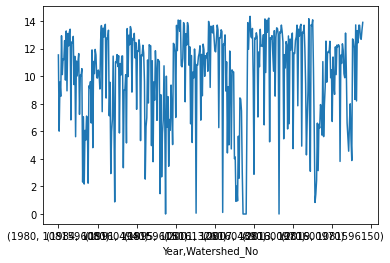

In [194]:
Watershed.groupby(['Year','Watershed_No']).mean()['Yield (tonne/ha)'].plot()

In [179]:
Watershed.set_index('Year', inplace=True)

In [182]:
Watershed['Yield (tonne/ha)'].

Year
1980     8.076190
1981    12.567935
1982    10.336549
1983     5.098279
1984     9.685371
          ...    
2011    12.186476
2012     2.363092
2013    11.974454
2014    10.884961
2015     6.223196
Name: Yield (tonne/ha), Length: 1412, dtype: float64

In [180]:
Watershed.groupby('Watershed_No')[]

In [158]:
Watershed.Lat.unique()

array(['-26.00', '-26.10'], dtype=object)

In [159]:
Watershed.Lon.unique()

array(['31.60'], dtype=object)

In [90]:
planting_dates = {}
for year in SiteFile.Date.dt.year.unique():
    if year != 2022:
        year_clim = SiteFile.set_index('Date').loc['{}'.format(year)]
        year_clim.reset_index(inplace=True)
        plant_date = get_plantdate(lat=lat, lon=lon, crop=cropname, irr_stat=irr_status, weatherfile=year_clim)
        start_window = pd.to_datetime(plant_date, infer_datetime_format=True)-pd.DateOffset(90)
        end_window = pd.to_datetime(plant_date, infer_datetime_format=True)+pd.DateOffset(90)
        window_clim = year_clim.set_index('Date').resample('7D').sum()
        arex = window_clim[start_window:end_window].loc[window_clim['Precipitation']>25].index[0]
        planting_dates[year] = arex.strftime("%m-%d")
        start_sim = arex-pd.DateOffset(90)

In [94]:
f'{1979}/01/01'

'1979/01/01'

In [96]:
start_sim.strftime('%Y/%m/%d')

'2021/07/03'

In [92]:
planting_dates.get(2021)

'10-01'

In [76]:
year_clim

,MinTemp,MaxTemp,Precipitation,ReferenceET
Date,,,,
2022-01-01,18.949524,32.527130,2.48,5.636418
2022-01-02,21.322418,27.044098,0.63,3.841484
2022-01-03,21.367950,28.580872,0.89,3.679201
2022-01-04,21.850250,31.236115,4.42,5.101156
2022-01-05,21.454620,33.520752,2.58,6.194154
...,...,...,...,...
2022-10-11,20.059265,33.020111,0.02,6.569203
2022-10-12,19.280334,35.889679,0.00,6.864384
2022-10-13,19.834961,35.599304,0.00,6.884019


In [55]:
start_date = pd.to_datetime(plant_date, infer_datetime_format=True)-pd.DateOffset(90)
end_date = pd.to_datetime(plant_date, infer_datetime_format=True)+pd.DateOffset(90)

In [58]:
TestClim = SiteFile.set_index('Date').resample('7D').sum()

In [61]:
arex = TestClim[start_date:end_date].loc[TestClim['Precipitation']>25]

In [65]:
arex.index[0]

Timestamp('1979-08-27 00:00:00')

In [46]:
Scenario =  [{'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'SugarCane', 'Irrigation':'ir'},
          {'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Maize', 'Irrigation':'ir'},
            {'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Sorghum', 'Irrigation':'ir'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Maize', 'Irrigation':'rf'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'SugarCane', 'Irrigation':'rf'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Sorghum', 'Irrigation':'rf'}]

for scenario in Scenario:
    print(scenario.get('Name'))
    for wshed in country_wsheds.hybas_id.unique()[1:2]:
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                # Metadata
                cropname = scenario.get('Crop')
                irr_status = scenario.get('Irrigation')
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                try:
                    Elevation = altitudo(lat=[lat], lon=[lon])
                    Elevation = Elevation[0].get('elevation')
                except:
                    print('Something wrong with elevation')
                # Soil profile
                try:
                    point_soil = get_soil_profile(lon=lon, lat=lat)
                except:
                    print('Didnt work for', lat,lon)
               # Climate
                SiteFile = get_climate(lat=lat, lon=lon)
                # Planting date
                plant_date = get_plantdate(lat=lat, lon=lon, crop=cropname, irr_stat=irr_status)
                
                if plant_date == '01-01':
                    plant_date = '01-02'
    
                print('Running watershed number:',wshed, 'Lat: ',lat, 'Lon: ',lon,'Elevation:',
                      Elevation,'Plant Date:', plant_date, 'Crop', cropname)
                
                # Crop
                if cropname == 'Maize':
                    crop_sim = Crop('Maize', planting_date='{}'.format(plant_date), Zmax=pnt_rootzoneD)
                else:
                    crop_sim = Crop('{}'.format(cropname), planting_date='{}'.format(plant_date))
                    
                # Initial water
                InitWC = InitialWaterContent(value=['FC'])
    
                # Irrigation
                irr_num = scenario.get('IrrNum')
                soilmt = scenario.get('SMT')
                
                if soilmt is None:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                else:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))
            
                # Run the model
                model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                          sim_end_time=f'{2021}/12/31',
                          weather_df=SiteFile,
                          soil=point_soil,
                          crop=crop_sim,
                          initial_water_content=InitWC,
                          irrigation_management=net_irrigation)
                try:
                    model.run_model(till_termination=True)
                except:
                    traceback_output = traceback.format_exc()
                    print('Model didnt run for:', lat,lon,'Error:', traceback_output)
                
                out = model._outputs.final_stats
                out['Lat'] = lat
                out['Lon'] = lon
                out['Watershed_No'] = wshed
                scene = str(scenario.get('Name'))
                out['Scenario'] = scene
                out['Harvest Date (YYYY/MM/DD)'] = out['Harvest Date (YYYY/MM/DD)'].dt.year
                # Write to csv
                out.to_csv(os.path.join(DataDir,'Output','CSVs','{}_{}_{}_yield.csv'.format(cropname, scene, wshed)))

dataset = aggregate_yields('Output/CSVs')
dataset = dataset.rename_vars({'Yield (t/ha)':'Yield'})
dataset.to_netcdf(os.path.join(DataDir,'Output','NetCDF','Swaziland_Yields.nc'))

High_Input
Calculating Evapotranspiration
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Plant Date: 01-02 Crop SugarCane
High_Input
Calculating Evapotranspiration
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Plant Date: 11-01 Crop Maize
High_Input
Calculating Evapotranspiration
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Plant Date: 12-01 Crop Sorghum
Low_Input
Calculating Evapotranspiration
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Plant Date: 11-01 Crop Maize
Low_Input
Calculating Evapotranspiration
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Plant Date: 01-02 Crop SugarCane
Low_Input
Calculating Evapotranspiration
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Plant Date: 12-01 Crop Sorghum


ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray

In [53]:
def get_plantdate(lat, lon, crop, irr_stat, weatherfile):
    calendar = xr.open_dataset(os.path.join(DataDir,'Crop/Crop_Calendar/{}_{}_ggcmi_crop_calendar_phase3_v1.01.nc4').format(crop, irr_stat))
    pnt_date = calendar.sel(lon=lon,lat=lat,  method="nearest")
    pnt_date = pnt_date.planting_day.values
    sdate = weatherfile.Date.dt.year.unique()[0]
    strt_date = date(int(sdate), 1, 1)
    plant_date = strt_date + timedelta(days=int(pnt_date) - 1)
    plant_date = plant_date.strftime("%m-%d")
    return(plant_date)

In [54]:
Scenario =  [{'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'SugarCane', 'Irrigation':'ir'},
              {'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Maize', 'Irrigation':'ir'},
            {'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Sorghum', 'Irrigation':'ir'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Maize', 'Irrigation':'rf'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'SugarCane', 'Irrigation':'rf'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Sorghum', 'Irrigation':'rf'}]

for scenario in Scenario:
    print(scenario.get('Name'))
    for wshed in country_wsheds.hybas_id.unique():
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                # Metadata
                cropname = scenario.get('Crop')
                irr_status = scenario.get('Irrigation')
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                try:
                    Elevation = altitudo(lat=[lat], lon=[lon])
                    Elevation = Elevation[0].get('elevation')
                except:
                    print('Something wrong with elevation')
                # Soil profile
                try:
                    point_soil = get_soil_profile(lon=lon, lat=lat)
                except:
                    print('Didnt work for', lat,lon)
               # Climate
                SiteFile = get_climate(lat=lat, lon=lon)
                # Planting date
                plant_date = get_plantdate(lat=lat, lon=lon, crop=cropname, irr_stat=irr_status, weatherfile=SiteFile)
                
                print(plant_date)
                if plant_date == '01-01':
                    plant_date = '01-02'
    
                print('Running watershed number:',wshed, 'Lat: ',lat, 'Lon: ',lon,'Elevation:',
                      Elevation,'Plant Date:', plant_date, 'Crop', cropname)
                
                # Crop
                if cropname == 'Maize':
                    crop_sim = Crop('Maize', planting_date='{}'.format(plant_date), Zmax=pnt_rootzoneD)
                else:
                    crop_sim = Crop('{}'.format(cropname), planting_date='{}'.format(plant_date))
                    
                # Initial water
                InitWC = InitialWaterContent(value=['FC'])
    
                # Irrigation
                irr_num = scenario.get('IrrNum')
                soilmt = scenario.get('SMT')
                
                if soilmt is None:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                else:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))
            
                # Run the model
                model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                          sim_end_time=f'{2021}/12/31',
                          weather_df=SiteFile,
                          soil=point_soil,
                          crop=crop_sim,
                          initial_water_content=InitWC,
                          irrigation_management=net_irrigation)
                try:
                    model.run_model(till_termination=True)
                except:
                    traceback_output = traceback.format_exc()
                    print('Model didnt run for:', lat,lon,'Error:', traceback_output)
                
                out = model._outputs.final_stats
                out['Lat'] = lat
                out['Lon'] = lon
                out['Watershed_No'] = wshed
                scene = str(scenario.get('Name'))
                out['Scenario'] = scene
                out['Harvest Date (YYYY/MM/DD)'] = out['Harvest Date (YYYY/MM/DD)'].dt.year
                # Write to csv
                out.to_csv(os.path.join(DataDir,'Output','CSVs','{}_{}_{}_yield.csv'.format(cropname, scene, wshed)))

#dataset = aggregate_yields('Output/CSVs')
#dataset = dataset.rename_vars({'Yield (t/ha)':'Yield'})
#dataset.to_netcdf(os.path.join(DataDir,'Output','NetCDF','Swaziland_Yields.nc'))

High_Input
Calculating Evapotranspiration
01-01
Running watershed number: 1081599280 Lat:  -26.00 Lon:  31.60 Elevation: 331.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081599280 Lat:  -26.10 Lon:  31.60 Elevation: 404.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081600610 Lat:  -26.00 Lon:  31.40 Elevation: 819.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081600610 Lat:  -26.00 Lon:  31.50 Elevation: 383.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081600320 Lat:  -26.00 Lon:  31.10 Elevation: 974.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081599210 Lat:  -25.90 Lon:  31

Calculating Evapotranspiration
01-01
Running watershed number: 1081609490 Lat:  -27.00 Lon:  31.00 Elevation: 1226.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081609490 Lat:  -27.00 Lon:  31.10 Elevation: 1006.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081609490 Lat:  -27.00 Lon:  31.20 Elevation: 965.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081609490 Lat:  -27.10 Lon:  31.10 Elevation: 1026.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081608200 Lat:  -26.90 Lon:  31.60 Elevation: 356.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081608200 Lat:  -26.90 Lon:  31.70 Elevation: 251.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081608200 Lat:  -26.90 Lon:  31.80 Elev

Calculating Evapotranspiration
01-01
Running watershed number: 1081605930 Lat:  -26.30 Lon:  31.00 Elevation: 1363.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081605930 Lat:  -26.30 Lon:  31.10 Elevation: 1371.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081605930 Lat:  -26.40 Lon:  31.00 Elevation: 1417.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081605930 Lat:  -26.40 Lon:  31.10 Elevation: 1104.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081605930 Lat:  -26.40 Lon:  31.20 Elevation: 743.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081605930 Lat:  -26.40 Lon:  31.30 Elevation: 775.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081605930 Lat:  -26.50 Lon:  31.20 Ele

Calculating Evapotranspiration
10-17
Running watershed number: 1081600610 Lat:  -26.00 Lon:  31.50 Elevation: 383.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081600320 Lat:  -26.00 Lon:  31.10 Elevation: 974.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081599210 Lat:  -25.90 Lon:  31.50 Elevation: 451.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081596150 Lat:  -25.90 Lon:  31.60 Elevation: 350.0 Plant Date: 10-17 Crop Maize
Didnt work for -26.00 31.70
Calculating Evapotranspiration
10-17
Running watershed number: 1081596150 Lat:  -26.00 Lon:  31.70 Elevation: 322.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081596080 Lat:  -25.80 Lon:  31.30 Elevation: 604.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081596080 Lat:  -25.80 Lon:  31.40 Ele

Calculating Evapotranspiration
10-17
Running watershed number: 1081608210 Lat:  -26.80 Lon:  31.90 Elevation: 168.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
11-01
Running watershed number: 1081608210 Lat:  -26.80 Lon:  32.00 Elevation: 228.5 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
11-01
Running watershed number: 1081608210 Lat:  -26.80 Lon:  32.10 Elevation: 213.0 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081608210 Lat:  -26.90 Lon:  31.90 Elevation: 177.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
11-01
Running watershed number: 1081607320 Lat:  -26.70 Lon:  32.10 Elevation: 351.0 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081608140 Lat:  -26.40 Lon:  31.80 Elevation: 319.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081608140 Lat:  -26.50 Lon:  31.50 Elevation: 501.0 Plant Date: 10

Calculating Evapotranspiration
10-17
Running watershed number: 1081601830 Lat:  -26.30 Lon:  31.90 Elevation: 277.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
11-01
Running watershed number: 1081601830 Lat:  -26.30 Lon:  32.00 Elevation: 498.0 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081601830 Lat:  -26.40 Lon:  31.90 Elevation: 397.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081601360 Lat:  -26.00 Lon:  31.80 Elevation: 283.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081601360 Lat:  -26.10 Lon:  31.70 Elevation: 302.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081601360 Lat:  -26.10 Lon:  31.80 Elevation: 234.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081601360 Lat:  -26.20 Lon:  31.10 Elevation: 1452.0 Plant Date: 1

Calculating Evapotranspiration
11-21
Running watershed number: 1081604890 Lat:  -26.40 Lon:  30.90 Elevation: 1437.0 Plant Date: 11-21 Crop Sorghum
Calculating Evapotranspiration
11-21
Running watershed number: 1081604890 Lat:  -26.50 Lon:  30.90 Elevation: 1214.0 Plant Date: 11-21 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081613260 Lat:  -27.20 Lon:  31.60 Elevation: 548.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081613260 Lat:  -27.20 Lon:  31.70 Elevation: 352.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081613260 Lat:  -27.30 Lon:  31.50 Elevation: 753.5 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081613260 Lat:  -27.30 Lon:  31.60 Elevation: 298.5 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081613260 Lat:  -27.30 Lon:  31.70 Elevation: 278.0 

Calculating Evapotranspiration
12-16
Running watershed number: 1081608140 Lat:  -26.50 Lon:  31.70 Elevation: 376.5 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081608140 Lat:  -26.50 Lon:  31.80 Elevation: 251.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081608140 Lat:  -26.60 Lon:  31.50 Elevation: 381.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081608140 Lat:  -26.60 Lon:  31.60 Elevation: 345.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081608140 Lat:  -26.60 Lon:  31.70 Elevation: 296.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081608140 Lat:  -26.60 Lon:  31.80 Elevation: 251.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081608140 Lat:  -26.70 Lon:  31.50 Elevation: 372.5 Pl

Calculating Evapotranspiration
12-16
Running watershed number: 1081601360 Lat:  -26.20 Lon:  31.20 Elevation: 1282.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081601360 Lat:  -26.20 Lon:  31.50 Elevation: 531.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081601360 Lat:  -26.20 Lon:  31.60 Elevation: 329.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081601360 Lat:  -26.30 Lon:  31.20 Elevation: 1178.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081601360 Lat:  -26.30 Lon:  31.30 Elevation: 823.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081601360 Lat:  -26.30 Lon:  31.40 Elevation: 652.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081600560 Lat:  -26.20 Lon:  31.00 Elevation: 1458.5

Calculating Evapotranspiration
10-17
Running watershed number: 1081613850 Lat:  -27.20 Lon:  31.20 Elevation: 947.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081613210 Lat:  -27.20 Lon:  31.80 Elevation: 381.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081613210 Lat:  -27.20 Lon:  31.90 Elevation: 215.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081613210 Lat:  -27.30 Lon:  31.80 Elevation: 325.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081613210 Lat:  -27.30 Lon:  31.90 Elevation: 166.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081609500 Lat:  -27.00 Lon:  31.30 Elevation: 871.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081609500 Lat:  -27.00 Lon:  31.40 Elevation: 713.0 Plant Date: 10

Calculating Evapotranspiration
10-17
Running watershed number: 1081608140 Lat:  -26.70 Lon:  31.70 Elevation: 211.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081608140 Lat:  -26.70 Lon:  31.80 Elevation: 212.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081608140 Lat:  -26.80 Lon:  31.40 Elevation: 768.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081608140 Lat:  -26.80 Lon:  31.50 Elevation: 784.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081608140 Lat:  -26.80 Lon:  31.60 Elevation: 284.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081608140 Lat:  -26.80 Lon:  31.70 Elevation: 270.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081608140 Lat:  -26.80 Lon:  31.80 Elevation: 169.0 Plant Date: 10

Calculating Evapotranspiration
11-01
Running watershed number: 1081601690 Lat:  -26.10 Lon:  32.00 Elevation: 207.5 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081601690 Lat:  -26.20 Lon:  31.90 Elevation: 235.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081600680 Lat:  -26.00 Lon:  31.20 Elevation: 898.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081600680 Lat:  -26.00 Lon:  31.30 Elevation: 835.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081600680 Lat:  -26.10 Lon:  31.10 Elevation: 1131.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081600680 Lat:  -26.10 Lon:  31.20 Elevation: 1014.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
10-17
Running watershed number: 1081600680 Lat:  -26.10 Lon:  31.30 Elevation: 672.5 Plant Date: 

Calculating Evapotranspiration
01-01
Running watershed number: 1081609500 Lat:  -27.10 Lon:  31.20 Elevation: 1075.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081609500 Lat:  -27.10 Lon:  31.30 Elevation: 870.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081609500 Lat:  -27.10 Lon:  31.40 Elevation: 620.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081609500 Lat:  -27.10 Lon:  31.50 Elevation: 642.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081609500 Lat:  -27.10 Lon:  31.60 Elevation: 476.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081609500 Lat:  -27.10 Lon:  31.70 Elevation: 365.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081609500 Lat:  -27.10 Lon:  31.80 Elevat

Calculating Evapotranspiration
01-01
Running watershed number: 1081608140 Lat:  -26.80 Lon:  31.80 Elevation: 169.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081608140 Lat:  -26.90 Lon:  31.40 Elevation: 719.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081608140 Lat:  -26.90 Lon:  31.50 Elevation: 539.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081606140 Lat:  -26.60 Lon:  31.40 Elevation: 429.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081605920 Lat:  -26.50 Lon:  31.00 Elevation: 1085.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081605920 Lat:  -26.50 Lon:  31.10 Elevation: 1203.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081605920 Lat:  -26.60 Lon:  31.00 Eleva

Calculating Evapotranspiration
01-01
Running watershed number: 1081600680 Lat:  -26.10 Lon:  31.10 Elevation: 1131.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081600680 Lat:  -26.10 Lon:  31.20 Elevation: 1014.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081600680 Lat:  -26.10 Lon:  31.30 Elevation: 672.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081600680 Lat:  -26.10 Lon:  31.40 Elevation: 478.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081600680 Lat:  -26.10 Lon:  31.50 Elevation: 386.5 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081600680 Lat:  -26.20 Lon:  31.30 Elevation: 882.0 Plant Date: 01-02 Crop SugarCane
Calculating Evapotranspiration
01-01
Running watershed number: 1081600680 Lat:  -26.20 Lon:  31.40 Eleva

Calculating Evapotranspiration
12-16
Running watershed number: 1081609500 Lat:  -27.10 Lon:  31.70 Elevation: 365.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081609500 Lat:  -27.10 Lon:  31.80 Elevation: 302.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081609500 Lat:  -27.10 Lon:  31.90 Elevation: 237.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
11-21
Running watershed number: 1081609500 Lat:  -27.20 Lon:  31.30 Elevation: 943.0 Plant Date: 11-21 Crop Sorghum
Calculating Evapotranspiration
11-21
Running watershed number: 1081609500 Lat:  -27.20 Lon:  31.40 Elevation: 783.0 Plant Date: 11-21 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081609500 Lat:  -27.20 Lon:  31.50 Elevation: 670.5 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081609490 Lat:  -27.00 Lon:  31.00 Elevation: 1226.0 P

Calculating Evapotranspiration
12-16
Running watershed number: 1081605920 Lat:  -26.60 Lon:  31.00 Elevation: 1379.5 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081605920 Lat:  -26.60 Lon:  31.10 Elevation: 881.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081605920 Lat:  -26.60 Lon:  31.20 Elevation: 692.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081605920 Lat:  -26.60 Lon:  31.30 Elevation: 495.0 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
11-21
Running watershed number: 1081605930 Lat:  -26.30 Lon:  30.90 Elevation: 1471.5 Plant Date: 11-21 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081605930 Lat:  -26.30 Lon:  31.00 Elevation: 1363.5 Plant Date: 12-16 Crop Sorghum
Calculating Evapotranspiration
12-16
Running watershed number: 1081605930 Lat:  -26.30 Lon:  31.10 Elevation: 1371.

In [43]:
Scenario =  [{'Name':'High_Input','IrrNum':'4','SMT':'70','Crop':'Maize', 'Irrigation':'ir'},
            {'Name':'Low_Input','IrrNum':'0','Crop':'Maize', 'Irrigation':'rf'}]

for scenario in Scenario:
    print(scenario.get('Name'))
    for wshed in country_wsheds.hybas_id.unique():
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                # Metadata
                cropname = scenario.get('Crop')
                irr_status = scenario.get('Irrigation')
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                try:
                    Elevation = altitudo(lat=[lat], lon=[lon])
                    Elevation = Elevation[0].get('elevation')
                except:
                    print('Something wrong with elevation')
                # Soil profile
                try:
                    point_soil = get_soil_profile(lon=lon, lat=lat)
                except:
                    print('Didnt work for', lat,lon)
               # Climate
                SiteFile = get_climate(lat=lat, lon=lon)
                # Planting date
                plant_date = get_plantdate(lat=lat, lon=lon, crop=cropname, irr_stat=irr_status)
                
                if plant_date == '01-01':
                    plant_date = '01-02'
    
                print('Running watershed number:',wshed, 'Lat: ',lat, 'Lon: ',lon,'Elevation:',
                      Elevation,'Plant Date:', plant_date, 'Crop', cropname)
                
                # Crop
                if cropname == 'Maize':
                    crop_sim = Crop('Maize', planting_date='{}'.format(plant_date), Zmax=pnt_rootzoneD)
                else:
                    crop_sim = Crop('{}'.format(cropname), planting_date='{}'.format(plant_date))
                    
                # Initial water
                InitWC = InitialWaterContent(value=['FC'])
    
                # Irrigation
                irr_num = scenario.get('IrrNum')
                soilmt = scenario.get('SMT')
                
                if soilmt is None:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                else:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))
            
                # Run the model
                model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                          sim_end_time=f'{2021}/12/31',
                          weather_df=SiteFile,
                          soil=point_soil,
                          crop=crop_sim,
                          initial_water_content=InitWC,
                          irrigation_management=net_irrigation)
                try:
                    model.run_model(till_termination=True)
                except:
                    traceback_output = traceback.format_exc()
                    print('Model didnt run for:', lat,lon,'Error:', traceback_output)
                
                out = model._outputs.final_stats
                out['Lat'] = lat
                out['Lon'] = lon
                out['Watershed_No'] = wshed
                scene = str(scenario.get('Name'))
                out['Scenario'] = scene
                out['Harvest Date (YYYY/MM/DD)'] = out['Harvest Date (YYYY/MM/DD)'].dt.year
                # Write to csv
                out.to_csv(os.path.join(DataDir,'Output','CSVs','{}_{}_{}_yield.csv'.format(cropname, scene, wshed)))

dataset = aggregate_yields('Output/CSVs')
dataset = dataset.rename_vars({'Yield (t/ha)':'Yield'})
dataset.to_netcdf(os.path.join(DataDir,'Output','NetCDF','Swaziland_Yields.nc'))

High_Input
Calculating Evapotranspiration
Running watershed number: 1081599280 Lat:  -26.00 Lon:  31.60 Elevation: 331.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081599280 Lat:  -26.10 Lon:  31.60 Elevation: 404.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081600610 Lat:  -26.00 Lon:  31.40 Elevation: 819.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081600610 Lat:  -26.00 Lon:  31.50 Elevation: 383.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081600320 Lat:  -26.00 Lon:  31.10 Elevation: 974.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081599210 Lat:  -25.90 Lon:  31.50 Elevation: 451.0 Plant Date: 10-17 Crop Maize
Calculating Evap

Running watershed number: 1081609490 Lat:  -27.10 Lon:  31.10 Elevation: 1026.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608200 Lat:  -26.90 Lon:  31.60 Elevation: 356.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608200 Lat:  -26.90 Lon:  31.70 Elevation: 251.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608200 Lat:  -26.90 Lon:  31.80 Elevation: 213.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608200 Lat:  -27.00 Lon:  31.50 Elevation: 860.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608200 Lat:  -27.00 Lon:  31.60 Elevation: 491.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608200 Lat:  -27.00 Lon:  31.70 Elevation: 314.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 

Calculating Evapotranspiration
Running watershed number: 1081605930 Lat:  -26.50 Lon:  31.30 Elevation: 619.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081605930 Lat:  -26.50 Lon:  31.40 Elevation: 607.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1080012770 Lat:  -26.40 Lon:  32.00 Elevation: 539.0 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1080012770 Lat:  -26.50 Lon:  32.00 Elevation: 559.0 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1080012770 Lat:  -26.50 Lon:  32.10 Elevation: 329.0 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1080012770 Lat:  -26.60 Lon:  32.10 Elevation: 347.5 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081601440 Lat:  -26.20 Lon:  31.70 Elevation: 328.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspirat

Running watershed number: 1081596080 Lat:  -25.90 Lon:  31.40 Elevation: 781.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081606440 Lat:  -26.60 Lon:  30.80 Elevation: 1397.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081606440 Lat:  -26.60 Lon:  30.90 Elevation: 1415.0 Plant Date: 10-17 Crop Maize
Something wrong with elevation
Calculating Evapotranspiration
Running watershed number: 1081606440 Lat:  -26.70 Lon:  30.80 Elevation: 1415.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081606440 Lat:  -26.70 Lon:  30.90 Elevation: 1173.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081606440 Lat:  -26.70 Lon:  31.00 Elevation: 1118.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081606440 Lat:  -26.70 Lon:  31.10 Elevation: 979.0 Plant Date: 10-17 Crop Maize
Calculating Evapotrans

Calculating Evapotranspiration
Running watershed number: 1081608210 Lat:  -26.60 Lon:  31.90 Elevation: 253.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608210 Lat:  -26.60 Lon:  32.00 Elevation: 538.5 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608210 Lat:  -26.70 Lon:  31.90 Elevation: 210.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608210 Lat:  -26.70 Lon:  32.00 Elevation: 337.5 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608210 Lat:  -26.80 Lon:  31.90 Elevation: 168.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608210 Lat:  -26.80 Lon:  32.00 Elevation: 228.5 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081608210 Lat:  -26.80 Lon:  32.10 Elevation: 213.0 Plant Date: 11-01 Crop Maize
Calculating Evapotranspirat

Calculating Evapotranspiration
Running watershed number: 1081601440 Lat:  -26.40 Lon:  31.70 Elevation: 403.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081601830 Lat:  -26.20 Lon:  32.00 Elevation: 182.5 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081601830 Lat:  -26.30 Lon:  31.90 Elevation: 277.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081601830 Lat:  -26.30 Lon:  32.00 Elevation: 498.0 Plant Date: 11-01 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081601830 Lat:  -26.40 Lon:  31.90 Elevation: 397.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081601360 Lat:  -26.00 Lon:  31.80 Elevation: 283.0 Plant Date: 10-17 Crop Maize
Calculating Evapotranspiration
Running watershed number: 1081601360 Lat:  -26.10 Lon:  31.70 Elevation: 302.5 Plant Date: 10-17 Crop Maize
Calculating Evapotranspirat

ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray

In [45]:
out_files = glob.glob(os.path.join(DataDir,'Output/CSVs','*Maize.csv'))

country_yield = pd.DataFrame()
for file in out_files:
    dftmp = pd.read_csv(file, index_col=3)
    dftmp = dftmp[['crop Type',
       'Yield (tonne/ha)', 'Lat', 'Lon',
       'Watershed_No', 'Scenario']]
    if len(country_yield) == 0:
        country_yield = dftmp
    else:
        country_yield = pd.concat([country_yield, dftmp])

In [46]:
country_yield.reset_index(inplace=True)

In [47]:
test = country_yield.groupby(['Harvest Date (YYYY/MM/DD)','Scenario','Watershed_No']).mean()

KeyError: 'Harvest Date (YYYY/MM/DD)'

In [ ]:
test.reset_index(inplace=True)

In [43]:
test.set_index('Harvest Date (YYYY/MM/DD)', inplace=True)

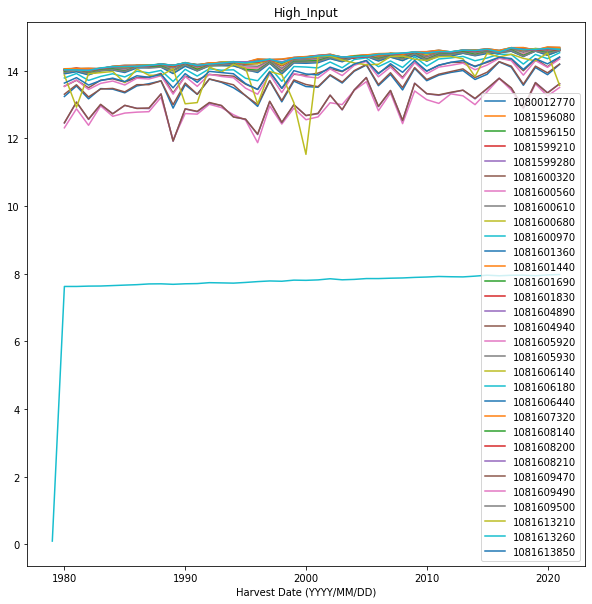

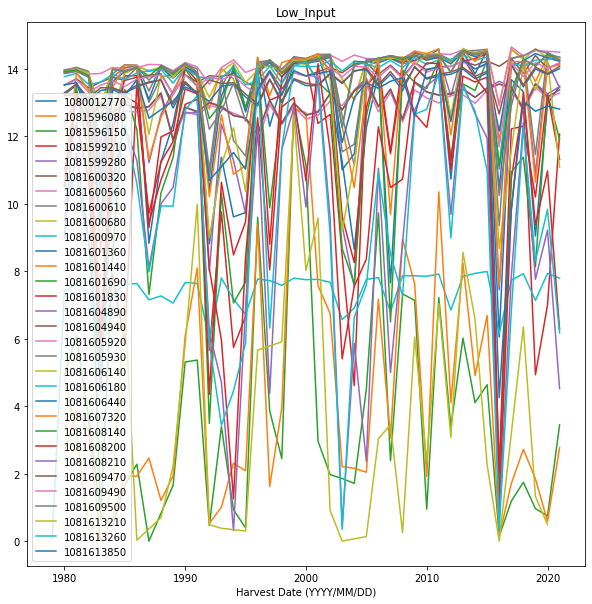

In [44]:
for i in test.Scenario.unique():
    fig, ax = plt.subplots()
    dftmp = test.loc[test['Scenario']==i]
    dftmp.groupby('Watershed_No')['Yield (tonne/ha)'].plot(ax=ax, title=i, figsize=(10,10))
    plt.legend()

In [49]:
country_yield.reset_index(inplace=True)

test = country_yield.groupby(['Lat','Lon','Scenario','Harvest Date (YYYY/MM/DD)','Watershed_No']).mean()



In [58]:
ds

<xarray.Dataset>
Dimensions:                    (Harvest Date (YYYY/MM/DD): 42, Lat: 15,
                                Lon: 14, Watershed_No: 31, Scenario: 2)
Coordinates:
  * Harvest Date (YYYY/MM/DD)  (Harvest Date (YYYY/MM/DD)) int64 1980 ... 2021
  * Lat                        (Lat) float64 -27.3 -27.2 -27.1 ... -26.0 -25.9
  * Lon                        (Lon) float64 30.8 30.9 31.0 ... 31.9 32.0 32.1
  * Watershed_No               (Watershed_No) int64 1080012770 ... 1081613850
  * Scenario                   (Scenario) object 'High_Input' 'Low_Input'
Data variables:
    Yield (tonne/ha)           (Harvest Date (YYYY/MM/DD), Lat, Lon, Watershed_No, Scenario) float64 ...

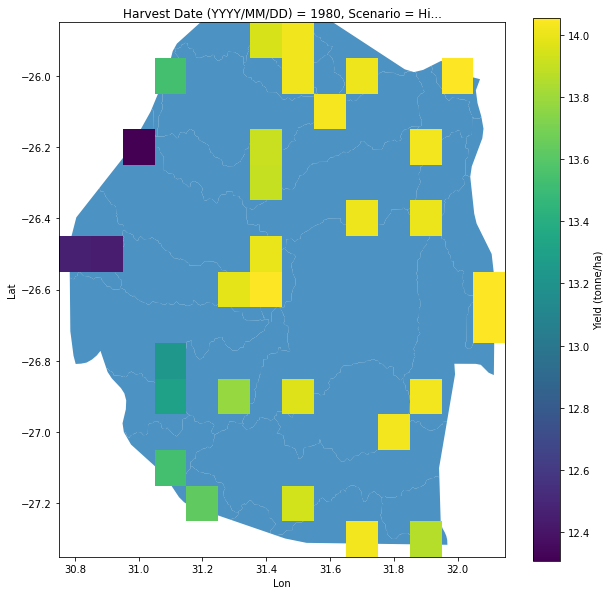

In [94]:
ds['Yield (tonne/ha)']

testds = ds['Yield (tonne/ha)'].mean(dim='Watershed_No')

fig, ax = plt.subplots(figsize=(10,10))

country_wsheds.plot(ax=ax, alpha=0.8)

testds[0,:,:,0].plot()

High_Input
Calculating Evapotranspiration
Running watershed number: 1081599280 Lat:  -26.00 Lon:  31.60 Elevation: 331.0 Plant Date: 01-02 Crop SugarCane
Model didnt run for: -26.00 31.60 Error: Traceback (most recent call last):
  File "/tmp/ipykernel_3408/4197091001.py", line 72, in <cell line: 8>
    model.run_model(till_termination=True)
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/aquacrop/core.py", line 285, in run_model
    ) = self._perform_timestep()
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/aquacrop/core.py", line 331, in _perform_timestep
    new_cond, param_struct, outputs = solution_single_time_step(
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/aquacrop/timestep/run_single_timestep.py", line 534, in solution_single_time_step
    outputs.final_stats.loc[row_gs] = [
  File "/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 716, in __setitem__
    iloc._setitem_with_indexer(indexer, value, se


KeyboardInterrupt



# Default testing

In [ ]:
custom = Soil('custom',cn=46,rew=7)

custom.add_layer(thickness=0.15,thWP=0.24,
                 thFC=0.40,thS=0.50,Ksat=155,
                 penetrability=100)

custom.add_layer_from_texture(thickness=0.3,
                              Sand=10,Clay=35,
                              OrgMat=2.5,penetrability=100)

custom.add_layer_from_texture(thickness=0.6,
                              Sand=20,Clay=45,
                              OrgMat=2.5,penetrability=100)

custom.add_layer_from_texture(thickness=1.0,
                              Sand=20,Clay=45,
                              OrgMat=2.5,penetrability=100)

custom.add_layer_from_texture(thickness=2.0,
                              Sand=20,Clay=45,
                              OrgMat=2.5,penetrability=100)


custom.profile

weather = pd.read_csv(os.path.join(DataDir,'Climate/04_sitefiles/AgERA5_Big_Bend.csv'), index_col=0, parse_dates=['Date'])

weather_data = weather

In [ ]:
Sites = [{'Name':'Big_Bend','Soil':'SandyLoam','Crop':'SugerCane'}]

for site in Sites:
    name = site.get('Name')
    print(name)

# Soil

sandy_loam = Soil(soil_type='SandyLoam')
clay_loam = Soil(soil_type='ClayLoam')

# Crop

maize = Crop('Maize', planting_date='10/01')
sugercane = Crop('SugarCane', planting_date='11/1', harvest_date='04/10',CGC=0.420,
                 CDC=0.226,
                 PlantPop=100000)


# Initial water
InitWC = InitialWaterContent(value=['FC'])

# Irrigation

#net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

net_irrigation = IrrigationManagement(irrigation_method=0)


# combine into aquacrop model and specify start and end simulation date
model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                      sim_end_time=f'{2022}/01/01',
                      weather_df=weather_data,
                      soil=custom,
                      crop=maize,
                      initial_water_content=InitWC)

# run model till termination
model.run_model(till_termination=True)

# model._outputs.water_flux.head()
# model._outputs.water_storage.head()
#model._outputs.crop_growth.head()
model._outputs.final_stats.head()

# Weather

In [127]:
weather = pd.read_csv(os.path.join(DataDir,'Climate/04_sitefiles/AgERA5_Big_Bend.csv'), index_col=0, parse_dates=['Date'])

In [128]:
weather_data = weather

## Define the sites and parameters we need to model

Here we automate the modelling process. The input parameters for a given site is specified and modelled.

In [129]:
Sites = [{'Name':'Big_Bend','Soil':'SandyLoam','Crop':'SugerCane'}]

for site in Sites:
    name = site.get('Name')
    print(name)

Big_Bend


In [130]:
# Soil

sandy_loam = Soil(soil_type='SandyLoam')
clay_loam = Soil(soil_type='ClayLoam')

# Crop

maize = Crop('Maize', planting_date='10/01')
sugercane = Crop('SugarCane', planting_date='11/1', harvest_date='04/10',CGC=0.420,
                 CDC=0.226,
                 PlantPop=100000)


# Initial water
InitWC = InitialWaterContent(value=['FC'])

# Irrigation

#net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

net_irrigation = IrrigationManagement(irrigation_method=0)


In [131]:
# combine into aquacrop model and specify start and end simulation date
model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                      sim_end_time=f'{2022}/01/01',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=maize,
                      initial_water_content=InitWC)

# run model till termination
model.run_model(till_termination=True)

# model._outputs.water_flux.head()
# model._outputs.water_storage.head()
#model._outputs.crop_growth.head()
model._outputs.final_stats.head()

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1980-02-10,404,11.412894,0
1,1,Maize,1981-02-10,770,12.533013,0
2,2,Maize,1982-02-10,1135,11.115747,0
3,3,Maize,1983-02-10,1500,8.331252,0
4,4,Maize,1984-02-10,1865,12.664608,0


In [132]:
out = model._outputs.final_stats

In [133]:
out

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1980-02-10,404,11.412894,0
1,1,Maize,1981-02-10,770,12.533013,0
2,2,Maize,1982-02-10,1135,11.115747,0
3,3,Maize,1983-02-10,1500,8.331252,0
4,4,Maize,1984-02-10,1865,12.664608,0
5,5,Maize,1985-02-10,2231,13.592043,0
6,6,Maize,1986-02-10,2596,13.751872,0
7,7,Maize,1987-02-10,2961,10.885517,0
8,8,Maize,1988-02-10,3326,12.623180,0
9,9,Maize,1989-02-10,3692,12.204667,0


## Weather station data

#### Big Bend

In [297]:
weather_bb = pd.read_excel(DataDir/'Weather/WW_Custom_CSW_554_20220920.xlsx', parse_dates=[1])
weather_bb.rename(columns={'Weather_Date':'Date','Min_Temp':'MinTemp','Max_Temp':'MaxTemp','Rainfall':'Precipitation','Daily_Evaporation':'ReferenceET'}, inplace=True)
weather_bb.drop(columns={'Station_ID','Wind', 'Temp_D8', 'Temp_W14', 'Temp_D14', 'Rel_Humidity_8',
       'Rel_Humidity_14', 'Min_Rel_Humidity', 'Max_Rel_Humidity',
       'Mean_Vapour', 'Apan_Evaporation',
       'Sunshine_Hours', 'Growth', 'Missing_Data_Code', 'SWC60', 'SWC100',
       'SWC140'}, inplace=True)
weather_bb = weather_bb[['MinTemp','MaxTemp','Precipitation', 'ReferenceET','Date']]

weather_data_bb = weather_bb.dropna(how='any')

In [346]:
weather_bb

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,18.06,29.08,0.0,4.40,1979-10-31
1,17.50,30.50,0.0,3.55,1979-11-01
2,16.50,31.00,0.0,5.44,1979-11-02
3,20.50,29.80,5.0,4.82,1979-11-03
4,20.30,37.30,0.0,6.86,1979-11-04
...,...,...,...,...,...
13538,18.80,39.50,0.0,7.83,2017-02-02
13539,24.60,35.50,0.0,8.09,2017-02-03
13540,20.00,36.00,0.0,7.88,2017-02-04
13541,21.50,38.80,0.0,8.28,2017-02-05


#### Mhlume RSSC 26'10'0, 31'48'0

In [298]:
weather_mh = pd.read_excel(DataDir/'Weather/WW_Custom_CSW_555_20220920.xlsx', parse_dates=[1])
weather_mh.rename(columns={'Weather_Date':'Date','Min_Temp':'MinTemp','Max_Temp':'MaxTemp','Rainfall':'Precipitation','Daily_Evaporation':'ReferenceET'}, inplace=True)
weather_mh.drop(columns={'Station_ID','Wind', 'Temp_D8', 'Temp_W14', 'Temp_D14', 'Rel_Humidity_8',
       'Rel_Humidity_14', 'Min_Rel_Humidity', 'Max_Rel_Humidity',
       'Mean_Vapour', 'Apan_Evaporation',
       'Sunshine_Hours', 'Growth', 'Missing_Data_Code', 'SWC60', 'SWC100',
       'SWC140'}, inplace=True)
weather_mh = weather_mh[['MinTemp','MaxTemp','Precipitation', 'ReferenceET','Date']]
weather_mh = weather_mh.dropna(how='any')

In [345]:
weather_mh

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,14.59,26.55,0.0,3.47,1968-04-30
1,15.80,30.50,0.0,4.42,1968-05-01
2,9.20,30.20,0.0,3.37,1968-05-02
3,12.70,32.10,0.0,3.80,1968-05-03
4,10.00,30.40,0.0,3.62,1968-05-04
...,...,...,...,...,...
17007,18.49,30.67,0.0,4.25,2014-11-22
17008,18.24,31.15,4.5,4.56,2014-11-23
17009,18.23,30.85,0.3,6.13,2014-11-24
17010,17.06,27.39,1.6,4.85,2014-11-25


#### Simunye Mlaula 26'12'0, 31'54'0

In [299]:
weather_sm = pd.read_excel(DataDir/'Weather/WW_Custom_CSW_553_20220920.xlsx', parse_dates=[1])
weather_sm.rename(columns={'Weather_Date':'Date','Min_Temp':'MinTemp','Max_Temp':'MaxTemp','Rainfall':'Precipitation','Daily_Evaporation':'ReferenceET'}, inplace=True)
weather_sm.drop(columns={'Station_ID','Wind', 'Temp_D8', 'Temp_W14', 'Temp_D14', 'Rel_Humidity_8',
       'Rel_Humidity_14', 'Min_Rel_Humidity', 'Max_Rel_Humidity',
       'Mean_Vapour', 'Apan_Evaporation',
       'Sunshine_Hours', 'Growth', 'Missing_Data_Code', 'SWC60', 'SWC100',
       'SWC140'}, inplace=True)
weather_sm = weather_sm[['MinTemp','MaxTemp','Precipitation', 'ReferenceET','Date']]

weather_sm = weather_sm.dropna(how='any')

In [344]:
weather_sm

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,14.29,26.74,0.0,3.14,1979-04-30
1,14.11,32.60,0.0,3.96,1979-05-01
2,19.00,32.90,0.0,5.14,1979-05-02
3,18.20,33.50,0.0,6.14,1979-05-03
4,19.90,28.40,0.0,5.18,1979-05-04
...,...,...,...,...,...
13715,17.75,36.06,0.0,6.79,2017-02-02
13716,21.40,33.28,0.0,7.38,2017-02-03
13717,19.39,34.02,0.0,7.44,2017-02-04
13718,20.27,36.66,0.0,7.74,2017-02-05


# Soil

In [359]:
sandy_loam = Soil(soil_type='SandyLoam')
clay_loam = Soil(soil_type='ClayLoam')

# Crop

In [441]:
maize = Crop('Maize', planting_date='10/01')
sugercane = Crop('SugarCane', planting_date='10/1', harvest_date='04/15',PlantMethod=1 )

# Initial water

In [445]:
InitWC = InitialWaterContent(value=['SAT'])

# Irrigation

In [399]:
net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

# Model

In [417]:
# combine into aquacrop model and specify start and end simulation date
model = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/10/01',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=sugercane,
                      initial_water_content=InitWC)

In [418]:
# run model till termination
model.run_model(till_termination=True)

True

In [419]:
# model._outputs.water_flux.head()
# model._outputs.water_storage.head()
#model._outputs.crop_growth.head()
model._outputs.final_stats.head()

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,SugarCane,2000-10-01,243,13.075364,0
1,1,SugarCane,2001-08-08,554,8.541564,0
2,2,SugarCane,2002-09-22,964,8.984006,0
3,3,SugarCane,2003-08-19,1295,8.211898,0
4,4,SugarCane,2004-10-01,1704,12.969710,0


## Model different soil

In [403]:
# combine into aquacrop model and specify start and end simulation date
model_clay = AquaCropModel(sim_start_time=f'{2000}/10/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=Soil('Clay'),
                      crop=wheat,
                      initial_water_content=InitWC)

model_clay.run_model(till_termination=True)

True

In [404]:
names=['Sandy Loam','Clay']

#combine our two output files
dflist=[model._outputs.final_stats,
        model_clay._outputs.final_stats] 

outlist=[]
for i in range(len(dflist)): # go through our two output files
    temp = pd.DataFrame(dflist[i]['Yield (tonne/ha)']) # extract the seasonal yield data
    temp['label']=names[i] # add the soil type label
    outlist.append(temp) # save processed results

# combine results
all_outputs = pd.concat(outlist,axis=0)

Text(0, 0.5, 'Yield (tonne/ha)')

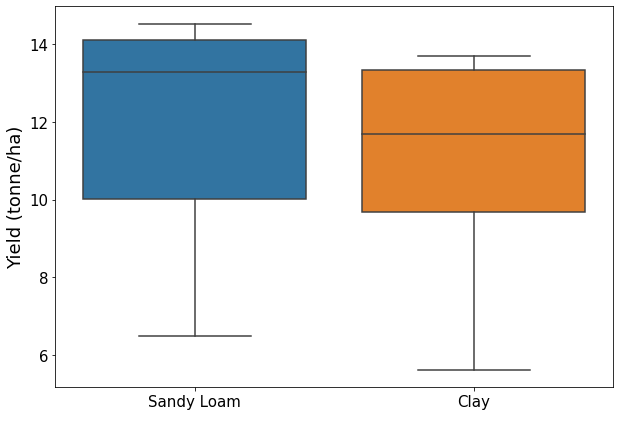

In [405]:
#create figure
fig,ax=plt.subplots(1,1,figsize=(10,7),)

# create box plot
sns.boxplot(data=all_outputs,x='label',y='Yield (tonne/ha)',ax=ax,)

# labels and font sizes
ax.tick_params(labelsize=15)
ax.set_xlabel(' ')
ax.set_ylabel('Yield (tonne/ha)',fontsize=18)

# Model different locations

In [517]:
InitWC = InitialWaterContent(value=['FC'])

In [713]:
net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

In [811]:
sugercane = Crop('SugarCane', planting_date='11/1', harvest_date='04/10',CGC=0.420,
                 CDC=0.226,
                 PlantPop=100000)

In [812]:
sugercane = Crop('SugarCane', planting_date='10/1', harvest_date='04/10')

In [813]:
sandy_loam = Soil(soil_type='SandyLoam')
clay_loam = Soil(soil_type='ClayLoam')

In [814]:
# combine into aquacrop model and specify start and end simulation date
model_a = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=clay_loam,
                      crop=sugercane,
                     initial_water_content=InitWC)
model_a.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_bb = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_bb,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        groundwater=GroundWater(water_table='Y',
                                       dates=[f'{2000}/10/01'],
                                       values=[1]),
                        irrigation_management=net_irrigation)
model_bb.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_mh = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_mh,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_mh.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_sm = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_sm,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_sm.run_model(till_termination=True)

True

In [815]:
names=['Big Bend','Mhlume','Simunye Mlaula', 'Grid Weather']

#combine our two output files
dflist=[model_bb._outputs.final_stats,
        model_mh._outputs.final_stats, model_sm._outputs.final_stats, 
        model_a._outputs.final_stats] 

outlist=[]
for i in range(len(dflist)): # go through our two output files
    temp = pd.DataFrame(dflist[i]['Yield (tonne/ha)']) # extract the seasonal yield data
    temp['label']=names[i] # add the soil type label
    outlist.append(temp) # save processed results

# combine results
all_outputs = pd.concat(outlist,axis=0)

Text(0, 0.5, 'Yield (tonne/ha)')

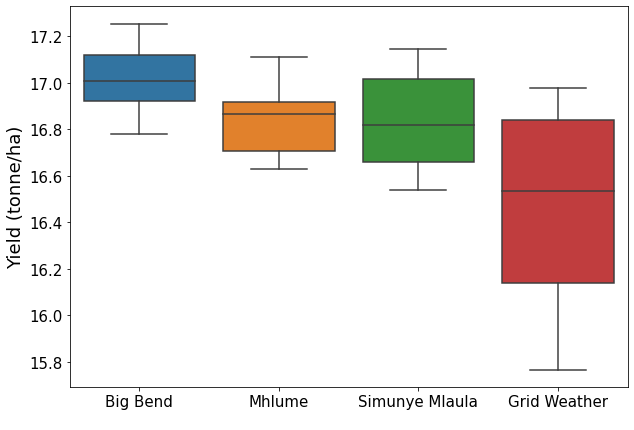

In [816]:
#create figure
fig,ax=plt.subplots(1,1,figsize=(10,7),)

# create box plot
sns.boxplot(data=all_outputs,x='label',y='Yield (tonne/ha)',ax=ax,)

# labels and font sizes
ax.tick_params(labelsize=15)
ax.set_xlabel(' ')
ax.set_ylabel('Yield (tonne/ha)',fontsize=18)

In [804]:
model_sm._outputs.final_stats.to_excel('MS.xlsx')

In [ ]:
## Initial Water
InitWC = InitialWaterContent(value=['FC'])

##Irrigation
net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

##Crop
sugercane = Crop('SugarCane', planting_date='11/1', harvest_date='04/10',CGC=0.420,
                 CDC=0.226,
                 PlantPop=100000)
##Management


##Groundwater




# combine into aquacrop model and specify start and end simulation date
model_a = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=clay_loam,
                      crop=sugercane,
                     initial_water_content=InitWC)
model_a.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_bb = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_bb,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        groundwater=GroundWater(water_table='Y',
                                       dates=[f'{2000}/10/01'],
                                       values=[1]),
                        irrigation_management=net_irrigation)
model_bb.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_mh = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_mh,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_mh.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_sm = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_sm,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_sm.run_model(till_termination=True)

# Custom soils

In [74]:
custom = Soil('custom',cn=46,rew=7)

In [75]:
custom.add_layer(thickness=custom.zSoil,thWP=0.24,
                 thFC=0.40,thS=0.50,Ksat=155,
                 penetrability=100)

In [76]:
custom = Soil('custom',cn=46,rew=7)
custom.add_layer_from_texture(thickness=custom.zSoil,
                              Sand=10,Clay=35,
                              OrgMat=2.5,penetrability=100)

In [77]:
custom.profile

,Comp,Layer,dz,dzsum,zBot,z_top,zMid,th_dry,th_wp,th_fc,th_s,Ksat,penetrability,tau
0,0,1.0,0.1,0.1,0.1,0.0,0.05,0.1075,0.215,0.382,0.511,136.4,100,0.48
1,1,1.0,0.1,0.2,0.2,0.1,0.15,0.1075,0.215,0.382,0.511,136.4,100,0.48
2,2,1.0,0.1,0.3,0.3,0.2,0.25,0.1075,0.215,0.382,0.511,136.4,100,0.48
3,3,1.0,0.1,0.4,0.4,0.3,0.35,0.1075,0.215,0.382,0.511,136.4,100,0.48
4,4,1.0,0.1,0.5,0.5,0.4,0.45,0.1075,0.215,0.382,0.511,136.4,100,0.48
5,5,1.0,0.1,0.6,0.6,0.5,0.55,0.1075,0.215,0.382,0.511,136.4,100,0.48
6,6,1.0,0.1,0.7,0.7,0.6,0.65,0.1075,0.215,0.382,0.511,136.4,100,0.48
7,7,1.0,0.1,0.8,0.8,0.7,0.75,0.1075,0.215,0.382,0.511,136.4,100,0.48
8,8,1.0,0.1,0.9,0.9,0.8,0.85,0.1075,0.215,0.382,0.511,136.4,100,0.48
9,9,1.0,0.1,1.0,1.0,0.9,0.95,0.1075,0.215,0.382,0.511,136.4,100,0.48


In [78]:
custom = Soil('custom',cn=46,rew=7)

custom.add_layer(thickness=0.3,thWP=0.24,
                 thFC=0.40,thS=0.50,Ksat=155,
                 penetrability=100)

custom.add_layer_from_texture(thickness=1.5,
                              Sand=10,Clay=35,
                              OrgMat=2.5,penetrability=100)

custom.profile

,Comp,Layer,dz,dzsum,zBot,z_top,zMid,th_dry,th_wp,th_fc,th_s,Ksat,penetrability,tau
0,0,1.0,0.1,0.1,0.1,0.0,0.05,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
1,1,1.0,0.1,0.2,0.2,0.1,0.15,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
2,2,1.0,0.1,0.3,0.3,0.2,0.25,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
3,3,2.0,0.1,0.4,0.4,0.3,0.35,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
4,4,2.0,0.1,0.5,0.5,0.4,0.45,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
5,5,2.0,0.1,0.6,0.6,0.5,0.55,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
6,6,2.0,0.1,0.7,0.7,0.6,0.65,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
7,7,2.0,0.1,0.8,0.8,0.7,0.75,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
8,8,2.0,0.1,0.9,0.9,0.8,0.85,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
9,9,2.0,0.1,1.0,1.0,0.9,0.95,0.1075,0.215,0.382,0.511,136.4,100.0,0.48


# Groundwater

In [81]:
# constant groundwater depth of 2m
gw_model = AquaCropModel(sim_start_time=f'{1995}/10/01',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      initial_water_content=InitWC,            
                      groundwater=GroundWater(water_table='Y',
                                       dates=[f'{1995}/10/01'],
                                       values=[2])
                    )

In [82]:
gw_model.run_model(till_termination=True)

True

In [83]:
gw_model._outputs.final_stats

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1996-02-10,131,13.848702,0
1,1,Maize,1997-02-10,497,14.265383,0
2,2,Maize,1998-02-10,862,14.290760,0
3,3,Maize,1999-02-10,1227,14.179298,0
4,4,Maize,2000-02-10,1592,14.421791,0
5,5,Maize,2001-02-10,1958,14.339423,0
6,6,Maize,2002-02-10,2323,14.306611,0
7,7,Maize,2003-02-10,2688,14.473195,0
8,8,Maize,2004-02-10,3053,14.317730,0
9,9,Maize,2005-02-10,3419,14.510294,0


In [84]:
# model._outputs.water_flux.head()
# model._outputs.water_storage.head()
# model._outputs.crop_growth.head()
model._outputs.final_stats.head()

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1996-02-10,131,13.688820,0
1,1,Maize,1997-02-10,497,14.279829,0
2,2,Maize,1998-02-10,862,14.284479,0
3,3,Maize,1999-02-10,1227,13.711132,0
4,4,Maize,2000-02-10,1592,14.434245,0


# Climate

In [320]:
variables = [
    ("2m_temperature","24_hour_minimum"),
    ("2m_temperature","24_hour_maximum"),
    ("precipitation_flux","daily"),
    ("solar_radiation_flux", "daily"),
    ("vapour_pressure", "24_hour_mean"),
    ("10m_wind_speed", "24_hour_mean")]

selected_area = "SADC"

for variable in variables:      
    files = glob.glob(os.path.join('Data','Climate','2_aggregate','*{}_{}_{}*'.format(selected_area,variable[0],variable[1])))
    df = xr.open_mfdataset(files, parallel=True, engine="netcdf4", decode_times=True, chunks={'time': 1000},
                       data_vars='minimal', coords='minimal', compat='override')
    if not os.path.exists('Data/Climate/3_combined'):
        os.makedirs('Data/Climate/3_combined')
    print('Writing {}'.format(variable))
    df.to_netcdf('Data/Climate/3_combined/AgERA5_{}_{}_{}.nc'.format(selected_area,variable[0],variable[1]), mode='w')
    df.close()
    print('Finished writing {}'.format(variable))

Writing ('2m_temperature', '24_hour_minimum')
Finished writing ('2m_temperature', '24_hour_minimum')
Writing ('2m_temperature', '24_hour_maximum')
Finished writing ('2m_temperature', '24_hour_maximum')
Writing ('precipitation_flux', 'daily')
Finished writing ('precipitation_flux', 'daily')
Writing ('solar_radiation_flux', 'daily')
Finished writing ('solar_radiation_flux', 'daily')
Writing ('vapour_pressure', '24_hour_mean')
Finished writing ('vapour_pressure', '24_hour_mean')
Writing ('10m_wind_speed', '24_hour_mean')
Finished writing ('10m_wind_speed', '24_hour_mean')
